# Capstone 2: Predicting Lead Conversion — End‑to‑End Pipeline

*Auto-generated on 2025-08-27 07:55:50. This notebook is structured to run step-by-step. Fill in file paths and optional settings below and run each cell.*

# 1) Setup & Configuration

Specify file paths, ID columns, target label, and (optionally) partner companies to exclude to remove skew/leakage noted by VIVA panel.

In [2]:

# --- User Inputs (EDIT THESE) ---
# Paths to your two input files (Excel/CSV). You can also merge a single ABT if you already created one.
PATH_CONVERTED = "D:/Nikesh/BA Class Nikesh/Capstone Project/Nikesh_Capstone/Capstone 1/converted_leads_V1.xlsx"        # e.g., "/mnt/data/converted_leads.xlsx"
PATH_NOT_CONVERTED = "D:/Nikesh/BA Class Nikesh/Capstone Project/Nikesh_Capstone/Capstone 1/not_converted_L_V1.xlsx"   # e.g., "/mnt/data/not_converted_l.xlsx"

# Column names (edit to match your data schema)
ID_COL = "lead_id"          # unique row identifier if available (or set to None)
TARGET_COL = "converted"    # 1 for enrolled, 0 for not enrolled
ORG_COL = "Organization"    # organization/company column
WORKEXP_COL = "Work Experience"   # raw banded text (e.g., 'BELOW 4 YEARS'); we'll clean to numeric years
INDUSTRY_SIZE_COL = "Industry Size"  # e.g., "₹ 300 Cr", "21.6 Billion", etc.
BEHAVIORAL_SCORE_COL = "lead_score"  # CRM behavioral score column if present (else None)
TEXT_COLS = ["Job Title", "Industry", "Organization", "Publisher", "Type"]  # update as needed

# Optional: explicit list of partnered companies to exclude (to address skew/leakage)
PARTNER_COMPANIES = [
    # "Infosys", "TCS", "Accenture", "IBM"
]

# Auto-detection thresholds for potential partner-company skew among CONVERTED leads
AUTO_MIN_CONVERSIONS = 50      # minimum converted count to consider a company "dominant"
AUTO_MIN_CONV_RATE = 0.30      # or high conversion rate within company (heuristic)
AUTO_TOP_N = 3                 # or always exclude top-N orgs by converted count (set 0 to disable)

# Train/Validation split
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Export settings
EXPORT_EXCEL = "capstone2_outputs.xlsx"  # will contain predictions, probability bands, and lookalike lists
MODEL_DIR = "capstone2_models"           # where we persist encoders/models

print("Config loaded. Edit the paths and column names above if needed.")


Config loaded. Edit the paths and column names above if needed.


# 2) Imports & Utilities



In [3]:

import os, re, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Optional: XGBoost / LightGBM if installed
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# Imbalance handling
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMB = True
except Exception:
    HAS_IMB = False

from joblib import dump, load

# Plotting (NOTE: using matplotlib only, no seaborn, no custom colors)
import matplotlib.pyplot as plt

os.makedirs(MODEL_DIR, exist_ok=True)
print("Imports ready. XGB:", HAS_XGB, "| LGBM:", HAS_LGBM, "| imbalanced-learn:", HAS_IMB)


Imports ready. XGB: False | LGBM: True | imbalanced-learn: True


# 3) Load Data



In [4]:

def load_any(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    if path.suffix.lower() in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    elif path.suffix.lower() in [".csv"]:
        return pd.read_csv(path)
    else:
        raise ValueError("Unsupported file type for " + str(path))

df_conv = load_any(PATH_CONVERTED)
df_not = load_any(PATH_NOT_CONVERTED)

# enforce target labels
df_conv[TARGET_COL] = 1
df_not[TARGET_COL] = 0

print("Converted shape:", df_conv.shape, "| Not-converted shape:", df_not.shape)
display(df_conv.head(3))
display(df_not.head(3))


Converted shape: (1020, 29) | Not-converted shape: (28320, 34)


,Sl No,Form Name,Registered Name,Application No,Registered Email,Lead Score,Registered Mobile,Form Status,Payment Status,Payment Method,...,Bin,Type,Categoty,Gender,Lead Stage,Publisher Name,Application Owner,Application Completion Date,User Id,converted
0,3,M.SC IN CLOUD ARCHITECTURE AND SECURITY(LONG-T...,TEST HARITHA,RACE/2021-2/CAS-MSC/0001,HARITHA.J@NOPAPERFORMS.COM,245.0,`+91-8792173812,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,MALE,APPLIED,REFERRAL,MARCOM (MARKETING@RACE.REVA.EDU.IN),"25/01/2022, 12:04 PM",13508866,1
1,4,MBA IN BUSINESS ANALYTICS,VILMA FERNANDES,RACE/2017/1,VILMABFERNANDES@GMAIL.COM,89.0,`+91-9538098880,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,FEMALE,APPLIED,SOURCE NOT SET,MARCOM (MARKETING@RACE.REVA.EDU.IN),"23/11/2017, 07:32 PM",3929530,1
2,7,MS IN BUSINESS ANALYTICS,ANIL KUMAR DILAIR,RACE/2022-1/BA-MS/10003,ANILDILAIR@GMAIL.COM,123.0,`+91-9888057111,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,MALE,NOT ELIGIBLE,FACEBOOK,MARCOM (MARKETING@RACE.REVA.EDU.IN),"03/08/2022, 01:43 PM",13515201,1


,Sl. No,Registered Name,User Registration Date,Primary Traffic Channel,Primary Registration Campaign,Publisher Name,Registered Email,Registered Mobile,Program Interested in,Program Interested in2,...,Lead Score,Lead Score 2,Lead Score in Per,Lead Owner,Lead Owner2,Re-assigned On,Payment Approved,Lead Remark,User Id,converted
0,1,ANCHALA,"27/02/2025, 09:45:35 AM",OFFLINE,WEBSITE/REQUEST_CALLBACK/PGD_MBA_BA,WEBSITE,ANCHALAMURTHY29@GMAIL.COM,`+91-8639671757,MS IN BUSINESS ANALYTICS,MS IN BUSINESS ANALYTICS,...,12.0,12.0,NaN,CHAITHRA V (CHAITHRA.V@REVA.EDU.IN),CHAITHRA V (CHAITHRA.V@REVA.EDU.IN),"27/02/2025, 09:45 AM",NaN,"I RACE,A NEW EVENT HAS BEEN BOOKED.EVENT TYPEC...",13531159.0,0
1,2,SYED TAJ,"27/02/2025, 08:04:39 AM",PAID ADS,FACEBOOK/LEADAD/M TECH CYBER SECURITY | JAN_20214,FACEBOOK,LOVERRBOY88@GMAIL.COM,`+91-9035156852,NaN,NaN,...,10.0,10.0,NaN,CHAITHRA V (CHAITHRA.V@REVA.EDU.IN),CHAITHRA V (CHAITHRA.V@REVA.EDU.IN),"27/02/2025, 08:08 AM",NaN,NaN,13531158.0,0
2,3,ARHAM ALI,"27/02/2025, 01:06:38 AM",DIRECT,DIRECT/DIRECT/DIRECT,DIRECT,IYAMARHAM.ALI@GMAIL.COM,`+91-9986804240,NaN,NaN,...,31.0,31.0,NaN,MAHA SAMRUTHAA (MAHASAMRUTHAA.G@REVA.EDU.IN),MAHA SAMRUTHAA (MAHASAMRUTHAA.G@REVA.EDU.IN),"27/02/2025, 01:09 AM",NaN,NaN,13531157.0,0


In [5]:
df_conv.head()

,Sl No,Form Name,Registered Name,Application No,Registered Email,Lead Score,Registered Mobile,Form Status,Payment Status,Payment Method,...,Bin,Type,Categoty,Gender,Lead Stage,Publisher Name,Application Owner,Application Completion Date,User Id,converted
0,3,M.SC IN CLOUD ARCHITECTURE AND SECURITY(LONG-T...,TEST HARITHA,RACE/2021-2/CAS-MSC/0001,HARITHA.J@NOPAPERFORMS.COM,245.0,`+91-8792173812,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,MALE,APPLIED,REFERRAL,MARCOM (MARKETING@RACE.REVA.EDU.IN),"25/01/2022, 12:04 PM",13508866,1
1,4,MBA IN BUSINESS ANALYTICS,VILMA FERNANDES,RACE/2017/1,VILMABFERNANDES@GMAIL.COM,89.0,`+91-9538098880,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,FEMALE,APPLIED,SOURCE NOT SET,MARCOM (MARKETING@RACE.REVA.EDU.IN),"23/11/2017, 07:32 PM",3929530,1
2,7,MS IN BUSINESS ANALYTICS,ANIL KUMAR DILAIR,RACE/2022-1/BA-MS/10003,ANILDILAIR@GMAIL.COM,123.0,`+91-9888057111,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,MALE,NOT ELIGIBLE,FACEBOOK,MARCOM (MARKETING@RACE.REVA.EDU.IN),"03/08/2022, 01:43 PM",13515201,1
3,8,M.SC IN CLOUD ARCHITECTURE AND SECURITY(LONG-T...,SRINIVAS,RACE/2021-2/CAS-MSC/0004,KANISETTY.SRINIVAS@GMAIL.COM,120.0,`+91-9701831020,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,MALE,APPLIED,ORGANIC,MARCOM (MARKETING@RACE.REVA.EDU.IN),"11/03/2022, 11:18 AM",13512918,1
4,9,PGD/MTECH IN ARTIFICIAL INTELLIGENCE,VINAYA JAMES,RACE/2020/AI/4,MEENAKSHY.6@GMAIL.COM,248.0,`+91-9742394855,COMPLETE,PAYMENT APPROVED,ONLINE,...,Large,Indian,360000.0,FEMALE,APPLIED,ORGANIC,MARCOM (MARKETING@RACE.REVA.EDU.IN),"08/02/2020, 04:31 PM",13500461,1


# 4) Cleaning Helpers (WorkExp bands → years, Industry Size → billions, etc.)



In [6]:

def parse_years_band(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    # examples: 'BELOW 4 YEARS', '4-8 YEARS', '8-12 YEARS', '12-16 YEARS', '16-20 YEARS', 'ABOVE 20 YEARS'
    # We'll map to the midpoint in years (or a heuristic value)
    m = re.findall(r'\d+', s)
    if "below" in s and m:
        return max(0.0, float(m[0]) / 2)  # e.g., below 4 -> 2
    if "above" in s and m:
        return float(m[0]) + 2.0         # e.g., above 20 -> 22
    if len(m) >= 2:
        a, b = float(m[0]), float(m[1])
        return (a + b) / 2.0
    if len(m) == 1:
        return float(m[0])
    return np.nan

def parse_money_to_billions(x):
    """Converts strings like '₹ 300 Cr' or '21.6 Billion' or 'USD 2.5B' to a numeric (billions) where possible."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace(',', '')
    # detect billion
    if "billion" in s or s.endswith("b") or "bn" in s:
        nums = re.findall(r'[\d.]+', s)
        return float(nums[0]) if nums else np.nan
    # crores
    if "cr" in s or "crore" in s:
        nums = re.findall(r'[\d.]+', s)
        return float(nums[0]) / 100.0 if nums else np.nan  # 1 crore ~ 0.01 billion
    # million
    if "million" in s or "mn" in s or s.endswith("m"):
        nums = re.findall(r'[\d.]+', s)
        return float(nums[0]) / 1000.0 if nums else np.nan
    # plain number -> assume INR crores? Too risky; leave as NaN instead of guessing.
    nums = re.findall(r'[\d.]+', s)
    return np.nan if not nums else float(nums[0])

def basic_clean(df):
    df = df.copy()
    if WORKEXP_COL in df.columns:
        df["workexp_years"] = df[WORKEXP_COL].apply(parse_years_band)
    if INDUSTRY_SIZE_COL in df.columns:
        df["industry_size_bil"] = df[INDUSTRY_SIZE_COL].apply(parse_money_to_billions)
    return df

df_conv = basic_clean(df_conv)
df_not = basic_clean(df_not)
display(df_conv.head(3))


,Sl No,Form Name,Registered Name,Application No,Registered Email,Lead Score,Registered Mobile,Form Status,Payment Status,Payment Method,...,Type,Categoty,Gender,Lead Stage,Publisher Name,Application Owner,Application Completion Date,User Id,converted,workexp_years
0,3,M.SC IN CLOUD ARCHITECTURE AND SECURITY(LONG-T...,TEST HARITHA,RACE/2021-2/CAS-MSC/0001,HARITHA.J@NOPAPERFORMS.COM,245.0,`+91-8792173812,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,MALE,APPLIED,REFERRAL,MARCOM (MARKETING@RACE.REVA.EDU.IN),"25/01/2022, 12:04 PM",13508866,1,2.0
1,4,MBA IN BUSINESS ANALYTICS,VILMA FERNANDES,RACE/2017/1,VILMABFERNANDES@GMAIL.COM,89.0,`+91-9538098880,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,FEMALE,APPLIED,SOURCE NOT SET,MARCOM (MARKETING@RACE.REVA.EDU.IN),"23/11/2017, 07:32 PM",3929530,1,6.0
2,7,MS IN BUSINESS ANALYTICS,ANIL KUMAR DILAIR,RACE/2022-1/BA-MS/10003,ANILDILAIR@GMAIL.COM,123.0,`+91-9888057111,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,MALE,NOT ELIGIBLE,FACEBOOK,MARCOM (MARKETING@RACE.REVA.EDU.IN),"03/08/2022, 01:43 PM",13515201,1,14.0


# 5) Build ABT (combine, dedupe, drop leakage cols if any)



In [7]:

# Combine
abt = pd.concat([df_conv, df_not], ignore_index=True)

# Optional: drop leakage columns (add any columns that reveal the target in hindsight, e.g., 'application_status')
LEAKAGE_COLS = []  # e.g., ["Application Status", "Enrolled Date"]
for c in LEAKAGE_COLS:
    if c in abt.columns:
        abt.drop(columns=[c], inplace=True)

# Dedupe by ID if provided
if ID_COL and ID_COL in abt.columns:
    abt = abt.sort_values(by=[ID_COL]).drop_duplicates(subset=[ID_COL], keep="last")

print("ABT shape:", abt.shape)
display(abt.head(5))


ABT shape: (29340, 50)


,Sl No,Form Name,Registered Name,Application No,Registered Email,Lead Score,Registered Mobile,Form Status,Payment Status,Payment Method,...,Industry Size (Billion),Email Verification Status,Email Verification Status 2,Lead Score 2,Lead Score in Per,Lead Owner,Lead Owner2,Re-assigned On,Payment Approved,Lead Remark
0,3.0,M.SC IN CLOUD ARCHITECTURE AND SECURITY(LONG-T...,TEST HARITHA,RACE/2021-2/CAS-MSC/0001,HARITHA.J@NOPAPERFORMS.COM,245.0,`+91-8792173812,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,MBA IN BUSINESS ANALYTICS,VILMA FERNANDES,RACE/2017/1,VILMABFERNANDES@GMAIL.COM,89.0,`+91-9538098880,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,MS IN BUSINESS ANALYTICS,ANIL KUMAR DILAIR,RACE/2022-1/BA-MS/10003,ANILDILAIR@GMAIL.COM,123.0,`+91-9888057111,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,M.SC IN CLOUD ARCHITECTURE AND SECURITY(LONG-T...,SRINIVAS,RACE/2021-2/CAS-MSC/0004,KANISETTY.SRINIVAS@GMAIL.COM,120.0,`+91-9701831020,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.0,PGD/MTECH IN ARTIFICIAL INTELLIGENCE,VINAYA JAMES,RACE/2020/AI/4,MEENAKSHY.6@GMAIL.COM,248.0,`+91-9742394855,COMPLETE,PAYMENT APPROVED,ONLINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# --- Normalize Organization column to safe strings for grouping ---
from datetime import datetime as _dt

def _coerce_org_value(x):
    if pd.isna(x):
        return np.nan
    # Drop obvious non-name types
    if isinstance(x, (pd.Timestamp, _dt)):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        # If your orgs are truly numeric IDs, change this to: return str(int(x)) (or str(x))
        return np.nan
    s = str(x).strip()
    if s.lower() in {"", "nan", "none", "nat"}:
        return np.nan
    # collapse whitespace
    s = re.sub(r"\s+", " ", s)
    return s

if ORG_COL in abt.columns:
    # quick diagnosis
    print("Original ORG_COL dtype:", abt[ORG_COL].dtype)
    print("Sample types in ORG_COL:")
    print(abt[ORG_COL].dropna().head().apply(type))

    abt["__org_clean__"] = abt[ORG_COL].apply(_coerce_org_value)
    bad_before = abt[ORG_COL].isna().sum()
    bad_after  = abt["__org_clean__"].isna().sum()
    print(f"ORG invalids before: {bad_before} | after cleaning: {bad_after}")
else:
    print(f"Column {ORG_COL!r} not found; skipping org normalization.")


Original ORG_COL dtype: object
Sample types in ORG_COL:
0    <class 'str'>
2    <class 'str'>
3    <class 'str'>
4    <class 'str'>
6    <class 'str'>
Name: Organization, dtype: object
ORG invalids before: 7912 | after cleaning: 8032


# 6) Exclude Partner/Dominant Companies (manual list and/or auto-detect)

This addresses VIVA feedback: partnered/dominant companies may cause lookalike bias. We remove them before training.

In [9]:
# 6) Exclude Partner/Dominant Companies (manual list and/or auto-detect) — robust to mixed types

def auto_detect_dominant_companies_safe(
    abt, org_col_clean, target_col,
    min_conversions=50, min_conv_rate=0.30, top_n=3
):
    if org_col_clean not in abt.columns:
        print(f"{org_col_clean!r} missing; cannot auto-detect.")
        return [], pd.DataFrame()

    df = abt[[org_col_clean, target_col]].dropna(subset=[org_col_clean]).copy()
    if df.empty:
        print("No valid organizations after cleaning; skipping detection.")
        return [], pd.DataFrame()

    # Group by clean strings (safe), then compute stats
    g = df.groupby(org_col_clean, sort=False)[target_col].agg(['count', 'sum'])
    g['conv_rate'] = g['sum'] / g['count']

    # Detection heuristics
    by_volume = g.sort_values('sum', ascending=False)  # sort numeric, safe
    cand1 = list(by_volume[by_volume['sum'] >= min_conversions].index)
    cand2 = list(g[g['conv_rate'] >= min_conv_rate].index)
    cand3 = list(by_volume.head(top_n).index) if top_n > 0 else []

    detected = sorted(set(cand1 + cand2 + cand3))
    return detected, by_volume

# Decide which column to use for exclusion logic
org_key = "__org_clean__" if "__org_clean__" in abt.columns else ORG_COL

detected, org_stats = auto_detect_dominant_companies_safe(
    abt, org_key, TARGET_COL,
    min_conversions=AUTO_MIN_CONVERSIONS,
    min_conv_rate=AUTO_MIN_CONV_RATE,
    top_n=AUTO_TOP_N
)

print("Auto-detected dominant orgs (candidates):", detected)
display(org_stats.head(10) if isinstance(org_stats, pd.DataFrame) else org_stats)

# Manual list → normalize to strings same way to avoid mismatches
def _as_clean_str(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return None
    return _coerce_org_value(x)

manual_clean = [_as_clean_str(o) for o in PARTNER_COMPANIES if _as_clean_str(o)]

# Final exclusion list
exclude_orgs = sorted(set([o for o in manual_clean if o] + detected))
print("Excluding organizations:", exclude_orgs)

# Apply exclusion on the clean column; keep the original ORG_COL untouched for reporting
if org_key in abt.columns and exclude_orgs:
    before = abt.shape[0]
    mask_excl = abt[org_key].isin(exclude_orgs)
    abt = abt.loc[~mask_excl].copy()
    after = abt.shape[0]
    print(f"Rows removed due to org exclusion: {before - after} (remaining: {after})")
else:
    print("No org exclusion performed (column missing or empty list).")


Auto-detected dominant orgs (candidates): ['24-7 INTOUCH', '247.AI', '3AG NETWORK SOLUTIONS PVT LTD, BENGALURU', '3SOFT', 'ABDULWAHID ALHUSAM TRADING', 'ACCENTURE', 'ACETURTLE', 'ACKO', 'ACT FIBERNET', 'ADVANCE ANALYTIC SERVICE', 'AEGIS RAIL', 'AERODESIGN SOLUTIONS', 'AERONAUTICAL DEVELOPMENT ESTABLISHMENT DRDO', 'AFFINE ANALYTICS', 'AFORECYBERSEC', 'AHANA SYSTEMS AND SOLUTIONS', 'AIPL', 'AIRASIA', 'AIRBUS', 'ALDER BIOCHEM PRIVATE LIMITED', 'ALETHE CONSULTING SERVICES', 'ALLPAY LTD', 'ALTIOSTAR NETWORKS', 'ALTISOURCE BUSINESS SOLUTIONS PVT LTD', 'AMAR UJALA WEB SERVICES PVT. LTD.', 'AMD INDIA PVT LTD', 'ANALYTIC EDGE', 'ANTARES SYSTEM LIMITED', 'ANTRA INFO SOLUTIONS PRIVATE LIMITED', 'APPEN', 'APS COLLEGE OF ARTS AND SCIENCE', 'APTOS', 'APTTUS', 'ARMORCODE INC.', 'ARTHUR J GALLAGHER', 'ARYEN CAPITAL ADVISORS', 'ASM DIGITAL ENGINEERING PVT LTD BENGALURU', 'ASPIRE NXT PVT LTD', 'ASPL INFO SERVICES PVT. LTD.', 'ASPM CONSULTING OPC PRIVATE LIMITED', 'ATLAS SYSTEMS PVT LTD', 'ATMECS TECHNOL

,count,sum,conv_rate
__org_clean__,,,
INFOSYS,563,49,0.087034
IBM,488,36,0.073770
ACCENTURE,408,23,0.056373
CAPGEMINI,245,20,0.081633
COGNIZANT,269,17,0.063197
SAP,61,12,0.196721
ABB,61,12,0.196721
DELL,127,12,0.094488
AMAZON,202,11,0.054455


Excluding organizations: ['24-7 INTOUCH', '247.AI', '3AG NETWORK SOLUTIONS PVT LTD, BENGALURU', '3SOFT', 'ABDULWAHID ALHUSAM TRADING', 'ACCENTURE', 'ACETURTLE', 'ACKO', 'ACT FIBERNET', 'ADVANCE ANALYTIC SERVICE', 'AEGIS RAIL', 'AERODESIGN SOLUTIONS', 'AERONAUTICAL DEVELOPMENT ESTABLISHMENT DRDO', 'AFFINE ANALYTICS', 'AFORECYBERSEC', 'AHANA SYSTEMS AND SOLUTIONS', 'AIPL', 'AIRASIA', 'AIRBUS', 'ALDER BIOCHEM PRIVATE LIMITED', 'ALETHE CONSULTING SERVICES', 'ALLPAY LTD', 'ALTIOSTAR NETWORKS', 'ALTISOURCE BUSINESS SOLUTIONS PVT LTD', 'AMAR UJALA WEB SERVICES PVT. LTD.', 'AMD INDIA PVT LTD', 'ANALYTIC EDGE', 'ANTARES SYSTEM LIMITED', 'ANTRA INFO SOLUTIONS PRIVATE LIMITED', 'APPEN', 'APS COLLEGE OF ARTS AND SCIENCE', 'APTOS', 'APTTUS', 'ARMORCODE INC.', 'ARTHUR J GALLAGHER', 'ARYEN CAPITAL ADVISORS', 'ASM DIGITAL ENGINEERING PVT LTD BENGALURU', 'ASPIRE NXT PVT LTD', 'ASPL INFO SERVICES PVT. LTD.', 'ASPM CONSULTING OPC PRIVATE LIMITED', 'ATLAS SYSTEMS PVT LTD', 'ATMECS TECHNOLOGIES', 'AUTONOMY

In [11]:
# --- Normalize ALL categorical/text columns for consistency ---
# Run this AFTER Step 5 (ABT is ready) and AFTER Step 6 (optional org cleaning) but BEFORE Step 7.

import re
import numpy as np
import pandas as pd
from datetime import datetime as _dt

# 1) Ensure TEXT_COLS exists (adjust if your schema differs)
if 'TEXT_COLS' not in globals():
    TEXT_COLS = ["Job Title", "Industry", "Organization", "Publisher", "Type"]

# 2) If we created a cleaned org column in Step 6, prefer it for modeling
if "__org_clean__" in abt.columns and "Organization" in abt.columns:
    abt["Organization"] = abt["__org_clean__"]

# 3) Build cat_features from TEXT_COLS ∩ abt.columns
cat_features = [c for c in TEXT_COLS if c in abt.columns]
print("Categorical columns detected:", cat_features)

# 4) Cleaner to coerce to safe strings (or NaN)
def clean_categorical_value(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (pd.Timestamp, _dt)):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        return str(int(x)) if float(x).is_integer() else str(x)
    s = str(x).strip()
    if s.lower() in {"", "nan", "none", "nat"}:
        return np.nan
    return re.sub(r"\s+", " ", s)  # collapse whitespace

# 5) Apply cleaning to all categorical columns
for col in cat_features:
    abt[col] = abt[col].apply(clean_categorical_value)

# 6) Quick diagnostics
diag = (
    abt[cat_features]
    .dtypes.rename("dtype")
    .to_frame()
)
print("Post-clean dtypes:")
print(diag)

# Peek at a few unique values per column (optional)
for col in cat_features:
    print(f"\n{col} → sample uniques:", list(abt[col].dropna().unique()[:5]))


Categorical columns detected: ['Job Title', 'Industry', 'Organization', 'Type']
Post-clean dtypes:
               dtype
Job Title     object
Industry      object
Organization  object
Type          object

Job Title → sample uniques: ['Team Lead', 'ASSOCIATE', 'PSE', 'DESIGNER', 'ANALYST']

Industry → sample uniques: ['Engineering & Construction', 'Computers & IT Hardware', 'Financial Services', 'Retail', 'Consulting & Audit']

Organization → sample uniques: ['L&T', 'DELL', 'SOCIETE GENERALE', 'TARGET', 'EY']

Type → sample uniques: ['Indian', 'MNC']


In [13]:
# Detect likely behavioral score columns, set BEHAVIORAL_SCORE_COL if found
cands = [c for c in abt.columns if any(k in c.lower() for k in ["score","engagement","leadscore","crm score","behaviour","behavior"])]
print("Behavioral score candidates:", cands)

# If you see the right column in the above list, set it here EXACTLY:
# Example:
# BEHAVIORAL_SCORE_COL = "Lead Score"   # <-- change to the exact name in your data

# Make sure it's numeric (safe conversion)
if 'BEHAVIORAL_SCORE_COL' in globals() and BEHAVIORAL_SCORE_COL in abt.columns:
    abt[BEHAVIORAL_SCORE_COL] = pd.to_numeric(abt[BEHAVIORAL_SCORE_COL], errors="coerce")
    print(f"Using behavioral score column: {BEHAVIORAL_SCORE_COL}")
else:
    print("No behavioral score set yet. If you identified it above, set BEHAVIORAL_SCORE_COL and re-run this cell.")


Behavioral score candidates: ['Lead Score', 'Lead Score 2', 'Lead Score in Per']
No behavioral score set yet. If you identified it above, set BEHAVIORAL_SCORE_COL and re-run this cell.


In [14]:
# If your size/revenue column isn't named exactly INDUSTRY_SIZE_COL, try to find it and remap
possible_size_cols = [c for c in abt.columns if any(k in c.lower() for k in ["size","revenue","turnover","employees","company size","industry size"])]
print("Possible size/revenue columns:", possible_size_cols)

# If you see the right column in the list above, set it here EXACTLY:
# Example:
# INDUSTRY_SIZE_COL = "Company Revenue"   # <-- change to the exact name

# Recreate industry_size_bil if INDUSTRY_SIZE_COL is set
def parse_money_to_billions(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower().replace(',', '')
    nums = re.findall(r'[\d.]+', s)
    if not nums: return np.nan
    val = float(nums[0])
    if "billion" in s or s.endswith("b") or "bn" in s: return val
    if "cr" in s or "crore" in s: return val/100.0
    if "million" in s or "mn" in s or s.endswith("m"): return val/1000.0
    return np.nan  # avoid guessing units

if 'INDUSTRY_SIZE_COL' in globals() and INDUSTRY_SIZE_COL in abt.columns:
    abt["industry_size_bil"] = abt[INDUSTRY_SIZE_COL].apply(parse_money_to_billions)
    print(f"Created industry_size_bil from {INDUSTRY_SIZE_COL}")
else:
    print("No INDUSTRY_SIZE_COL set yet. If you identified it above, set INDUSTRY_SIZE_COL and re-run this cell.")


Possible size/revenue columns: ['Industry Size (Bilion)', 'Industry Size (Billion)']
No INDUSTRY_SIZE_COL set yet. If you identified it above, set INDUSTRY_SIZE_COL and re-run this cell.


In [15]:
# ---- Consolidate behavioral score into one numeric column (0–1 scale if needed)

import numpy as np
import pandas as pd

# Tell the code what columns you actually have (from your printout)
BEHAVIORAL_CANDIDATES = ["Lead Score", "Lead Score 2", "Lead Score in Per"]
present = [c for c in BEHAVIORAL_CANDIDATES if c in abt.columns]
print("Behavioral candidates present:", present)

def _to_numeric_series(s):
    return pd.to_numeric(s, errors="coerce")

def _to_numeric_percent(s):
    # handles like "87%" or "87.5"
    ser = pd.Series(s, copy=True).astype(str).str.replace("%", "", regex=False)
    return pd.to_numeric(ser, errors="coerce")

abt["behavioral_score"] = np.nan

# Priority order: Lead Score -> Lead Score 2 -> Lead Score in Per
if "Lead Score" in abt.columns:
    abt["behavioral_score"] = _to_numeric_series(abt["Lead Score"])

if "Lead Score 2" in abt.columns:
    abt["behavioral_score"] = abt["behavioral_score"].fillna(_to_numeric_series(abt["Lead Score 2"]))

if "Lead Score in Per" in abt.columns:
    tmp = _to_numeric_percent(abt["Lead Score in Per"])
    abt["behavioral_score"] = abt["behavioral_score"].fillna(tmp)

# Normalize to 0–1 if values look like 0–100
beh = abt["behavioral_score"]
if beh.dropna().max() > 1.5:   # likely a 0–100 scale
    abt["behavioral_score_norm"] = beh / 100.0
else:
    abt["behavioral_score_norm"] = beh

BEHAVIORAL_SCORE_COL = "behavioral_score_norm"
print(f"Set BEHAVIORAL_SCORE_COL = {BEHAVIORAL_SCORE_COL}")
print("Non-null behavioral rows:", abt[BEHAVIORAL_SCORE_COL].notna().sum())
print("Behavioral min/max:", abt[BEHAVIORAL_SCORE_COL].min(), abt[BEHAVIORAL_SCORE_COL].max())


Behavioral candidates present: ['Lead Score', 'Lead Score 2', 'Lead Score in Per']
Set BEHAVIORAL_SCORE_COL = behavioral_score_norm
Non-null behavioral rows: 26890
Behavioral min/max: -5.5 34.625


In [16]:
# ---- Map the Industry Size column and create 'industry_size_bil' numeric

cand_size = ["Industry Size (Billion)", "Industry Size (Bilion)"]  # handles the typo too
INDUSTRY_SIZE_COL = next((c for c in cand_size if c in abt.columns), None)
print("Chosen INDUSTRY_SIZE_COL:", INDUSTRY_SIZE_COL)

if INDUSTRY_SIZE_COL is not None:
    # These look like they're already in "Billion" units — just coerce to numeric.
    abt["industry_size_bil"] = pd.to_numeric(abt[INDUSTRY_SIZE_COL], errors="coerce")
    print("Created 'industry_size_bil'. Non-null rows:", abt["industry_size_bil"].notna().sum())
else:
    print("No industry size column mapped. Skipping.")


Chosen INDUSTRY_SIZE_COL: Industry Size (Billion)
Created 'industry_size_bil'. Non-null rows: 4591


In [17]:
# ---- Robust normalization of behavioral score to 0–1
import numpy as np
import pandas as pd

RAW_COL = BEHAVIORAL_SCORE_COL  # currently "behavioral_score_norm" from your previous cell, but it's actually raw-ish
SAFE_COL = "behavioral_score_01"

# Keep a copy of the raw combined score
abt["behavioral_score_raw"] = abt[RAW_COL]

# Compute robust bounds on non-null values
beh = abt[RAW_COL].astype(float)
valid = beh.dropna()
if valid.empty:
    print("No valid behavioral scores to normalize.")
else:
    p1, p99 = np.percentile(valid, [1, 99])
    # Handle degenerate case
    if p1 == p99:
        # fallback: z-score then squash to 0–1
        mu, sigma = valid.mean(), valid.std(ddof=0) or 1.0
        z = (beh - mu) / sigma
        # squash with logistic: 0..1
        abt[SAFE_COL] = 1 / (1 + np.exp(-z))
        print("Behavioral normalization used z-score + logistic (p1==p99).")
    else:
        clipped = beh.clip(lower=p1, upper=p99)
        abt[SAFE_COL] = (clipped - p1) / (p99 - p1)
        print(f"Behavioral normalization used percentile clipping [{p1:.3f}, {p99:.3f}] → 0–1.")

# Point BEHAVIORAL_SCORE_COL to the normalized column going forward
BEHAVIORAL_SCORE_COL = SAFE_COL
print("Final behavioral column for modeling:", BEHAVIORAL_SCORE_COL)
print("Non-null after norm:", abt[BEHAVIORAL_SCORE_COL].notna().sum(),
      "| min/max:", abt[BEHAVIORAL_SCORE_COL].min(), abt[BEHAVIORAL_SCORE_COL].max())

Behavioral normalization used percentile clipping [-0.100, 2.900] → 0–1.
Final behavioral column for modeling: behavioral_score_01
Non-null after norm: 26890 | min/max: 0.0 1.0


In [18]:
print("Behavioral column present for hybrid:", "behavioral_score_01" in abt.columns)
print("Non-null behavioral rows:", abt["behavioral_score_01"].notna().sum())

Behavioral column present for hybrid: True
Non-null behavioral rows: 26890


# 7) Feature Engineering & Preprocessing



In [19]:
# 7) Feature Engineering & Preprocessing (robust, reuses cleaned cat_features)

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# --- 1) Identify numeric features we engineered earlier (add more if you created them) ---
num_features = []
if "workexp_years" in abt.columns: num_features.append("workexp_years")
if "industry_size_bil" in abt.columns: num_features.append("industry_size_bil")

# --- 2) Determine categorical features ---
# Prefer the cat_features created by the normalization cell; else fall back to TEXT_COLS ∩ abt.columns
if 'cat_features' in globals() and isinstance(cat_features, list) and len(cat_features) > 0:
    cat_features_use = [c for c in cat_features if c in abt.columns]
else:
    if 'TEXT_COLS' not in globals():
        TEXT_COLS = ["Job Title", "Industry", "Organization", "Publisher", "Type"]
    cat_features_use = [c for c in TEXT_COLS if c in abt.columns]

print("Numeric features:", num_features)
print("Categorical features:", cat_features_use)

# --- 3) Behavioral score column (optional) ---
has_behavioral = ('BEHAVIORAL_SCORE_COL' in globals()
                  and BEHAVIORAL_SCORE_COL is not None
                  and BEHAVIORAL_SCORE_COL in abt.columns)

# --- 4) Build X, y ---
feature_cols = num_features + cat_features_use   # behavioral is NOT included here; it's added later for the hybrid section
X = abt[feature_cols].copy()
y = abt[TARGET_COL].astype(int).copy()

# --- 5) Preprocessors ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features_use)
    ]
)

# --- 6) Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape, "| has_behavioral:", has_behavioral)

Numeric features: ['workexp_years', 'industry_size_bil']
Categorical features: ['Job Title', 'Industry', 'Organization', 'Type']
Train shape: (21619, 6) Test shape: (5405, 6) | has_behavioral: True


# 8) Baselines: Logistic Regression & Decision Tree (with light tuning)



In [20]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test):
    model = estimator.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    metrics = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds, zero_division=0),
        "recall": recall_score(y_test, preds, zero_division=0),
        "f1": f1_score(y_test, preds, zero_division=0)
    }
    if proba is not None:
        try:
            metrics["auc"] = roc_auc_score(y_test, proba)
        except Exception:
            metrics["auc"] = np.nan
    print(name, "=>", metrics)
    return model, metrics, preds, proba

pipe_log = Pipeline(steps=[("prep", preprocessor),
                          ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))])

pipe_dt = Pipeline(steps=[("prep", preprocessor),
                         ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))])

log_params = {"clf__C":[0.1, 1, 2, 5]}
dt_params = {"clf__max_depth":[3,5,8,12,None],
             "clf__min_samples_split":[2,10,50],
             "clf__min_samples_leaf":[1,5,20]}

log_grid = GridSearchCV(pipe_log, log_params, cv=cv, scoring="f1", n_jobs=-1, refit=True)
dt_grid = GridSearchCV(pipe_dt, dt_params, cv=cv, scoring="f1", n_jobs=-1, refit=True)

log_best = log_grid.fit(X_train, y_train).best_estimator_
dt_best  = dt_grid.fit(X_train, y_train).best_estimator_

_, log_metrics, _, log_proba = evaluate_model("Logistic (best)", log_best, X_train, y_train, X_test, y_test)
_, dt_metrics,  _, dt_proba  = evaluate_model("DecisionTree (best)", dt_best, X_train, y_train, X_test, y_test)


Logistic (best) => {'accuracy': 0.968177613320999, 'precision': 0.32211538461538464, 'recall': 0.6836734693877551, 'f1': 0.43790849673202614, 'auc': np.float64(0.8999732736508961)}
DecisionTree (best) => {'accuracy': 0.9406105457909343, 'precision': 0.1978319783197832, 'recall': 0.7448979591836735, 'f1': 0.31263383297644537, 'auc': np.float64(0.8844008490903428)}


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import learning_curve

def evaluate_detailed(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    # --- Classification Report ---
    print(f"\n===== {model_name} — Classification Report =====")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{model_name} — Confusion Matrix")
    plt.colorbar()
    plt.xticks([0,1], ["Not Converted", "Converted"])
    plt.yticks([0,1], ["Not Converted", "Converted"])
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
    plt.show()
    
    # --- ROC Curve ---
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_test, y_proba):.3f})")
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} — ROC Curve")
        plt.legend(); plt.show()
    
    # --- Learning Curve ---
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring="f1", 
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_mean, "o-", label="Training score")
    plt.plot(train_sizes, test_mean, "o-", label="Cross-validation score")
    plt.title(f"{model_name} — Learning Curve (F1)")
    plt.xlabel("Training Set Size"); plt.ylabel("F1 Score")
    plt.legend(); plt.grid(True); plt.show()


===== Logistic Regression — Classification Report =====
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5307
           1       0.32      0.68      0.44        98

    accuracy                           0.97      5405
   macro avg       0.66      0.83      0.71      5405
weighted avg       0.98      0.97      0.97      5405



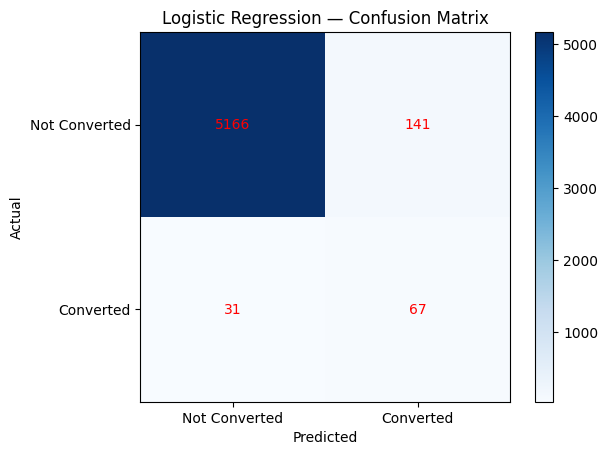

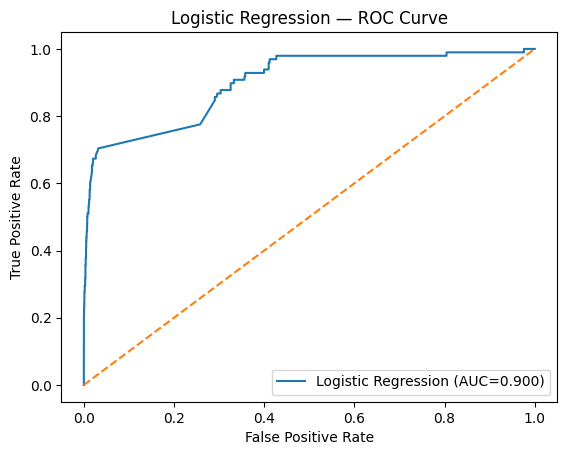

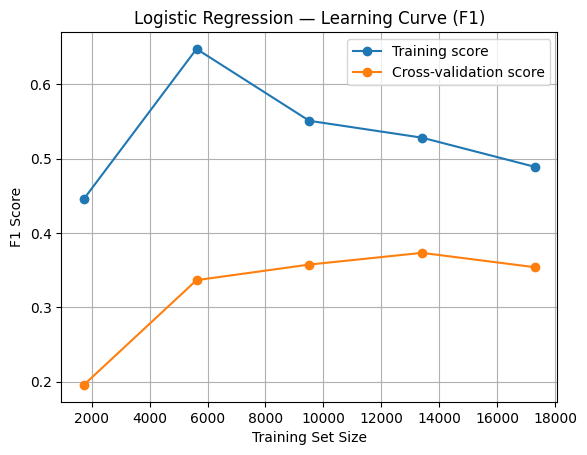


===== Decision Tree — Classification Report =====
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5307
           1       0.20      0.74      0.31        98

    accuracy                           0.94      5405
   macro avg       0.60      0.84      0.64      5405
weighted avg       0.98      0.94      0.96      5405



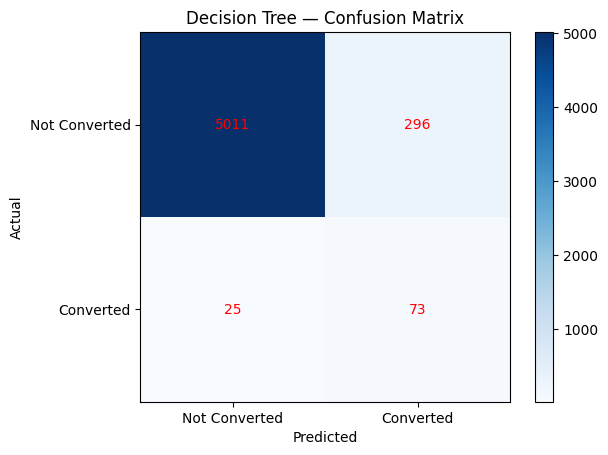

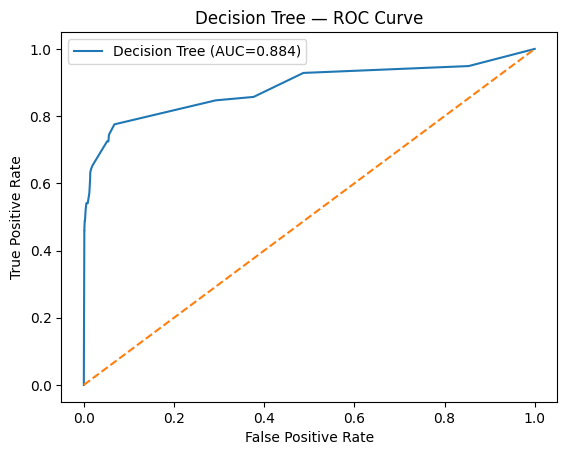

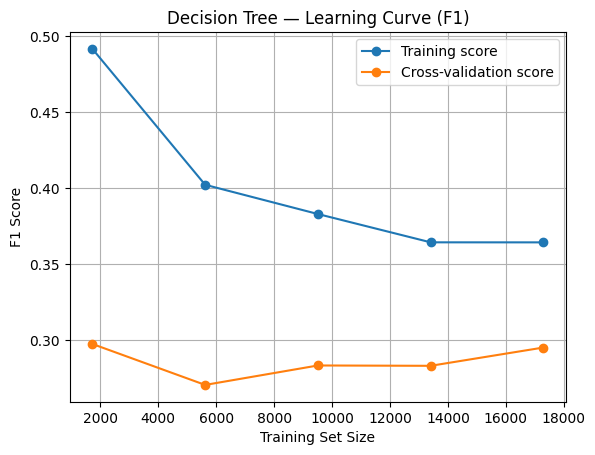

In [22]:
evaluate_detailed(log_best, X_train, y_train, X_test, y_test, model_name="Logistic Regression")
evaluate_detailed(dt_best, X_train, y_train, X_test, y_test, model_name="Decision Tree")

# 9) Advanced Model — RandomForest + SMOTE + Tuning + Evaluation


Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest+SMOTE (best) => {'accuracy': 0.9637372802960222, 'precision': 0.2688679245283019, 'recall': 0.5816326530612245, 'f1': 0.36774193548387096, 'auc': np.float64(0.8813744265371496)}

===== RandomForest + SMOTE — Classification Report =====
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5307
           1       0.27      0.58      0.37        98

    accuracy                           0.96      5405
   macro avg       0.63      0.78      0.67      5405
weighted avg       0.98      0.96      0.97      5405



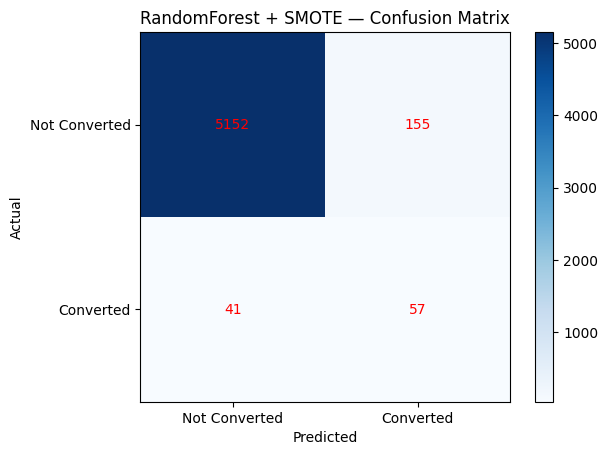

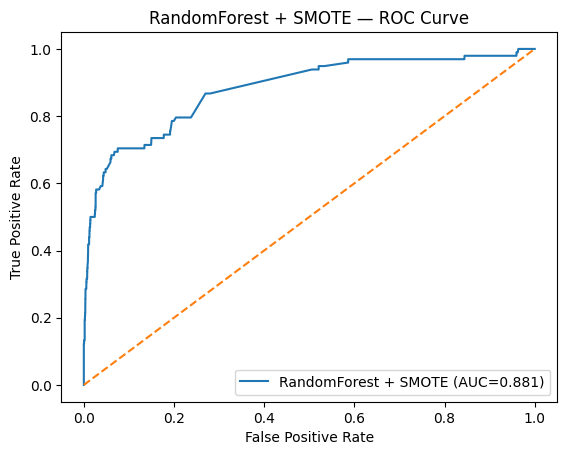

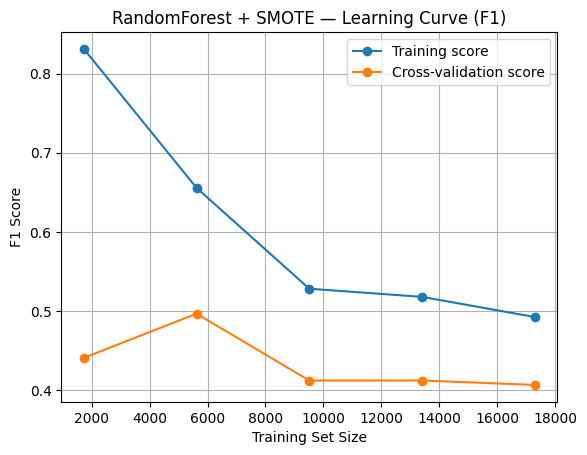

In [23]:
# 9) Advanced: RandomForest + SMOTE + RandomizedSearch + evaluation

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Pipeline with SMOTE
rf_pipe_smote = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
])

# Parameter search space (compact but effective)
rf_params_smote = {
    "clf__n_estimators": [300, 400, 600, 800],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_split": [2, 10, 50],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": ["sqrt", "log2", None]
}

rf_grid_smote = RandomizedSearchCV(
    rf_pipe_smote,
    rf_params_smote,
    n_iter=20,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    verbose=1
)

rf_best_smote = rf_grid_smote.fit(X_train, y_train).best_estimator_

# Quick metrics + probs (for Step 12 table)
_, rf_metrics_smote, _, rf_proba_smote = evaluate_model(
    "RandomForest+SMOTE (best)",
    rf_best_smote,
    X_train, y_train, X_test, y_test
)

# Detailed plots for report (classification report, confusion matrix, ROC, learning curve)
evaluate_detailed(
    rf_best_smote,
    X_train, y_train, X_test, y_test,
    model_name="RandomForest + SMOTE"
)


# 9B) XGBoost (with class imbalance weight) + tuning + evaluation


In [28]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   --- ------------------------------------ 4.7/56.8 MB 34.6 MB/s eta 0:00:02
   -------- ------------------------------- 11.8/56.8 MB 32.0 MB/s eta 0:00:02
   ------------- -------------------------- 18.9/56.8 MB 32.5 MB/s eta 0:00:02
   ----------------- ---------------------- 24.6/56.8 MB 31.2 MB/s eta 0:00:02
   ------------------- -------------------- 27.3/56.8 MB 27.0 MB/s eta 0:00:02
   --------------------- ------------------ 29.9/56.8 MB 24.6 MB/s eta 0:00:02
   ---------------------- ----------------- 32.2/56.8 MB 22.7 MB/s eta 0:00:02
   ------------------------ --------------- 34.6/56.8 MB 21.3 MB/s eta 0:00:02
   -------------------------- ------------- 37.2/56.8 MB 20.2 MB/s eta 0:00:01
   --------------------------- ------------ 39.3/56.8 MB 19.2 MB/s eta 0:00:01
   ---------------------------- ----------- 40.6/56.8 MB 18.0 MB/s eta 0:00:01
   ------------------------------ --------- 42.7/56.8 MB 17.5 


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBoost (weighted best) => {'accuracy': 0.9474560592044403, 'precision': 0.22647058823529412, 'recall': 0.7857142857142857, 'f1': 0.3515981735159817, 'auc': np.float64(0.9445620531988939)}

===== XGBoost (weighted) — Classification Report =====
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5307
           1       0.23      0.79      0.35        98

    accuracy                           0.95      5405
   macro avg       0.61      0.87      0.66      5405
weighted avg       0.98      0.95      0.96      5405



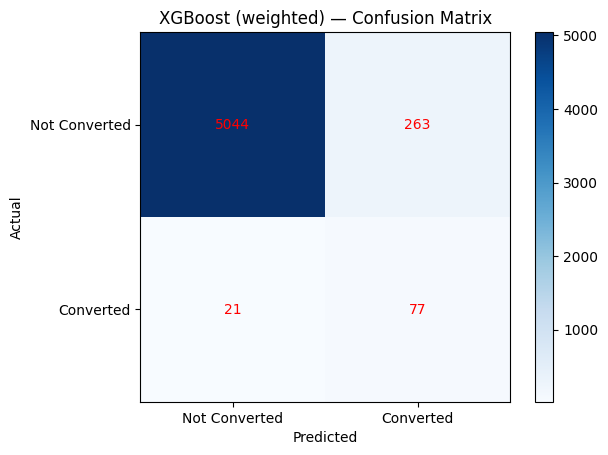

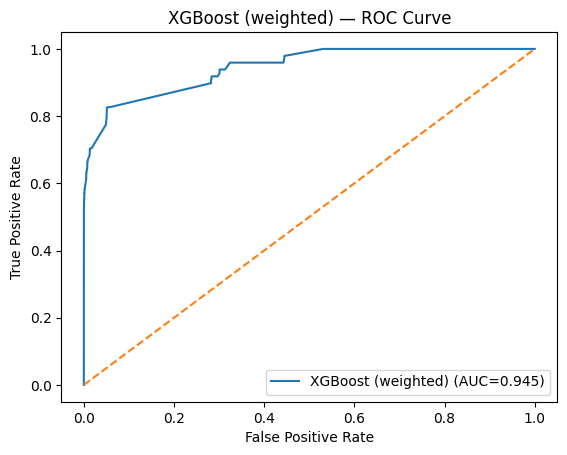

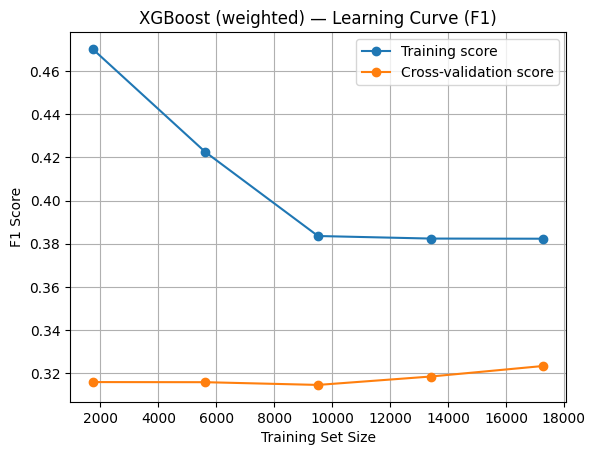

In [29]:
# 9B) XGBoost (weighted, no SMOTE) — RandomizedSearch + evaluation

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Compute imbalance weight
pos = y_train.sum()
neg = (y_train == 0).sum()
spw = float(neg) / float(pos)  # scale_pos_weight

xgb_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_estimators=600,
        scale_pos_weight=spw,
        n_jobs=-1
    ))
])

xgb_params = {
    "clf__max_depth": [3, 5, 7, 9],
    "clf__learning_rate": [0.02, 0.05, 0.1],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__min_child_weight": [1, 3, 5]
}

xgb_grid = RandomizedSearchCV(
    xgb_pipe, xgb_params,
    n_iter=20, cv=cv, scoring="f1",
    n_jobs=-1, random_state=RANDOM_STATE, refit=True, verbose=1
)

xgb_best = xgb_grid.fit(X_train, y_train).best_estimator_

_, xgb_metrics, _, xgb_proba = evaluate_model(
    "XGBoost (weighted best)",
    xgb_best, X_train, y_train, X_test, y_test
)

evaluate_detailed(
    xgb_best,
    X_train, y_train, X_test, y_test,
    model_name="XGBoost (weighted)"
)


# 9C) LightGBM (with class imbalance weight) + tuning + evaluation

In [30]:
!pip install lightgbm


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 391, number of negative: 21228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 21619, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018086 -> initscore=-3.994369
[LightGBM] [Info] Start training from score -3.994369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

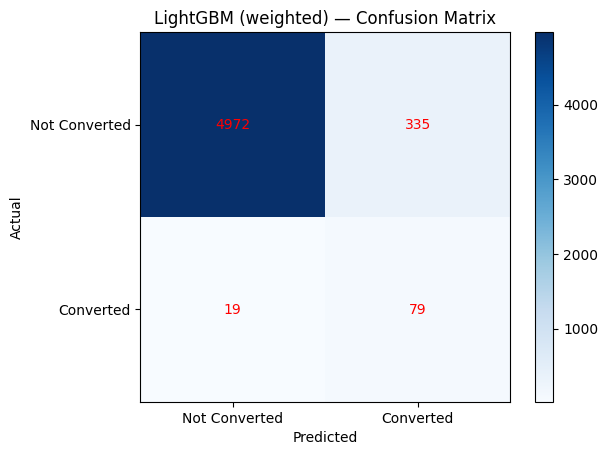

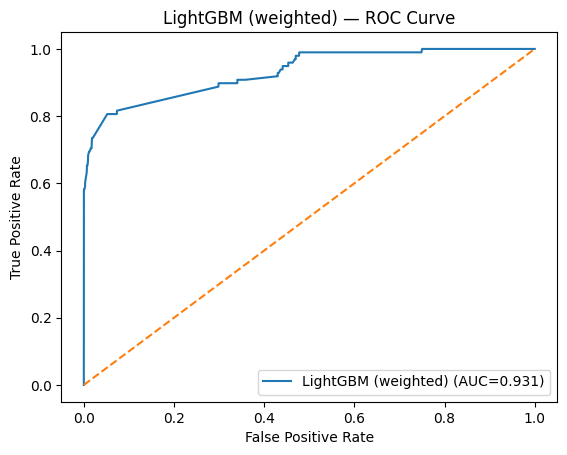

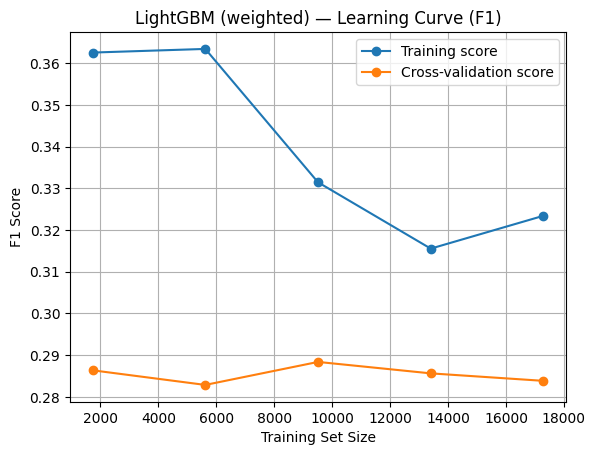

In [31]:
# 9C) LightGBM (weighted, no SMOTE) — RandomizedSearch + evaluation

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

# Reuse spw (scale_pos_weight) computed above
lgbm_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", lgb.LGBMClassifier(
        random_state=RANDOM_STATE,
        n_estimators=800,
        scale_pos_weight=spw,
        n_jobs=-1
    ))
])

lgbm_params = {
    "clf__num_leaves": [31, 63, 127, 255],
    "clf__learning_rate": [0.02, 0.05, 0.1],
    "clf__max_depth": [-1, 10, 20, 30],
    "clf__min_child_samples": [10, 20, 40],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0]
}

lgbm_grid = RandomizedSearchCV(
    lgbm_pipe, lgbm_params,
    n_iter=20, cv=cv, scoring="f1",
    n_jobs=-1, random_state=RANDOM_STATE, refit=True, verbose=1
)

lgbm_best = lgbm_grid.fit(X_train, y_train).best_estimator_

_, lgbm_metrics, _, lgbm_proba = evaluate_model(
    "LightGBM (weighted best)",
    lgbm_best, X_train, y_train, X_test, y_test
)

evaluate_detailed(
    lgbm_best,
    X_train, y_train, X_test, y_test,
    model_name="LightGBM (weighted)"
)


# 10) Demographic Score vs Behavioral Score (comparison + correlation)



Correlation between Demographic probability and Behavioral score: 0.1251


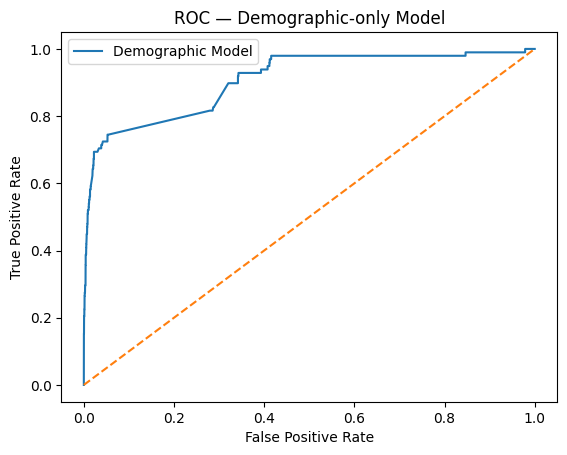

In [32]:

# Demographic-only feature set (exclude behavioral score if present)
demo_features = num_features + cat_features
X_demo = abt[demo_features].copy()

X_demo_train, X_demo_test, y_demo_train, y_demo_test = train_test_split(
    X_demo, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

demo_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, [c for c in num_features if c in X_demo.columns]),
        ("cat", categorical_transformer, [c for c in cat_features if c in X_demo.columns])
    ]
)

demo_clf = LogisticRegression(max_iter=200, class_weight="balanced")
demo_pipe = Pipeline(steps=[("prep", demo_preprocessor), ("clf", demo_clf)])
demo_pipe.fit(X_demo_train, y_demo_train)
demo_proba = demo_pipe.predict_proba(X_demo_test)[:,1]

# If behavioral score exists, compute correlation with demographic probability
if has_behavioral:
    # align indices
    behav = abt.loc[X_demo_test.index, BEHAVIORAL_SCORE_COL].copy()
    # basic cleaning for behavioral score
    behav = pd.to_numeric(behav, errors="coerce")
    corr = np.corrcoef(demo_proba, behav.fillna(0))[0,1]
    print("Correlation between Demographic probability and Behavioral score:", round(corr,4))
else:
    print("Behavioral score column not available; skipping correlation.")

# ROC curve for demographic model
fpr, tpr, _ = roc_curve(y_demo_test, demo_proba)
plt.figure()
plt.plot(fpr, tpr, label="Demographic Model")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — Demographic-only Model")
plt.legend()
plt.show()


# A1) Scatter (or density) — Demographic probability vs Behavioral (0–1)

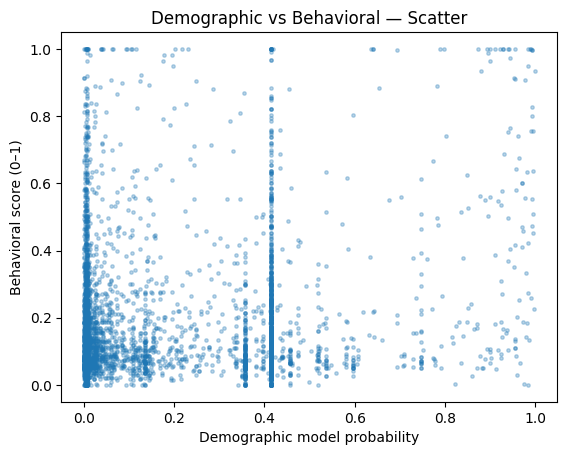

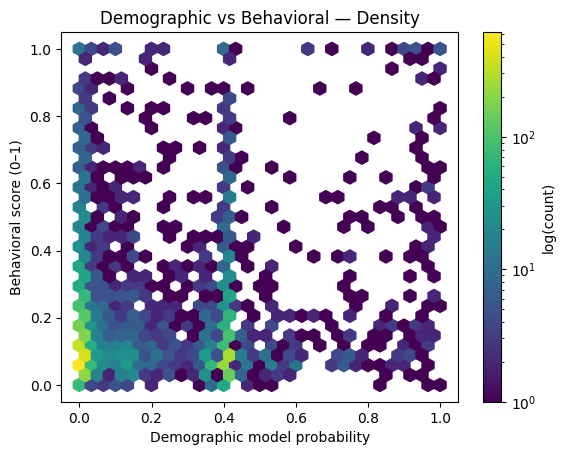

In [34]:
# Scatter (and optional density) of Demographic prob vs Behavioral 0–1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "behavioral_score_01" in abt.columns, "behavioral_score_01 missing"

rel = pd.DataFrame({
    "demo_proba": demo_proba,  # <-- corrected
    "behavioral_01": pd.to_numeric(abt.loc[X_demo_test.index, "behavioral_score_01"], errors="coerce")
}).dropna()

# Plain scatter
plt.figure()
plt.scatter(rel["demo_proba"], rel["behavioral_01"], s=6, alpha=0.3)
plt.xlabel("Demographic model probability"); plt.ylabel("Behavioral score (0–1)")
plt.title("Demographic vs Behavioral — Scatter")
plt.show()

# OPTIONAL: density (hexbin) — clearer for large N
plt.figure()
hb = plt.hexbin(rel["demo_proba"], rel["behavioral_01"], gridsize=30, bins="log")
plt.xlabel("Demographic model probability"); plt.ylabel("Behavioral score (0–1)")
plt.title("Demographic vs Behavioral — Density")
cb = plt.colorbar(hb); cb.set_label("log(count)")
plt.show()


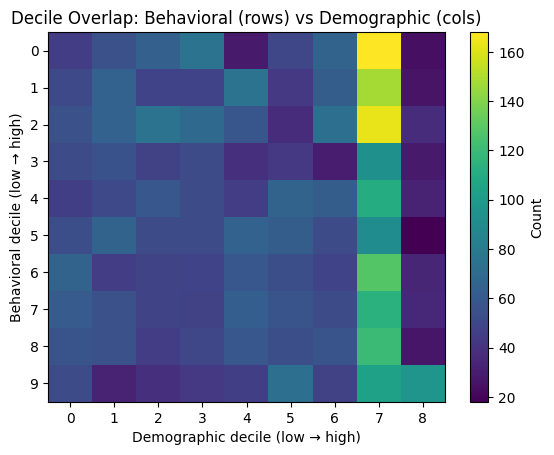

Top-behavioral deciles vs demo deciles (counts):


demo_decile,0,1,2,3,4,5,6,7,8
behav_decile,,,,,,,,,
7,61,55,49,47,63,57,53,114,35
8,57,55,45,50,59,54,57,120,27
9,53,33,39,43,46,73,47,104,96


In [35]:
# Decile overlap heatmap: Behavioral (rows) vs Demographic (cols)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_deciles(series):
    s = pd.Series(series)
    # try qcut; if too many ties, fall back to rank percentiles
    try:
        return pd.qcut(s, 10, labels=False, duplicates="drop")
    except Exception:
        r = s.rank(pct=True)
        return pd.cut(r, bins=np.linspace(0,1,11), labels=False, include_lowest=True)

df_rel = rel.copy()
df_rel["demo_decile"]  = safe_deciles(df_rel["demo_proba"])
df_rel["behav_decile"] = safe_deciles(df_rel["behavioral_01"])

xtab = pd.crosstab(df_rel["behav_decile"], df_rel["demo_decile"]).sort_index().sort_index(axis=1)

plt.figure()
plt.imshow(xtab.values, aspect="auto")
plt.title("Decile Overlap: Behavioral (rows) vs Demographic (cols)")
plt.xlabel("Demographic decile (low → high)")
plt.ylabel("Behavioral decile (low → high)")
plt.colorbar(label="Count")
plt.xticks(range(xtab.shape[1]), range(xtab.shape[1]))
plt.yticks(range(xtab.shape[0]), range(xtab.shape[0]))
plt.show()

print("Top-behavioral deciles vs demo deciles (counts):")
display(xtab.tail(3))


# 11) Hybrid Model (Demographic + Behavioral)

If behavioral score exists, we append it as a numeric feature and train a unified model; else this section gracefully skips.

Hybrid Accuracy: 0.9478260869565217
Hybrid Precision: 0.24444444444444444
Hybrid Recall: 0.8979591836734694
Hybrid F1: 0.38427947598253276
Hybrid AUC: 0.9686215356691009


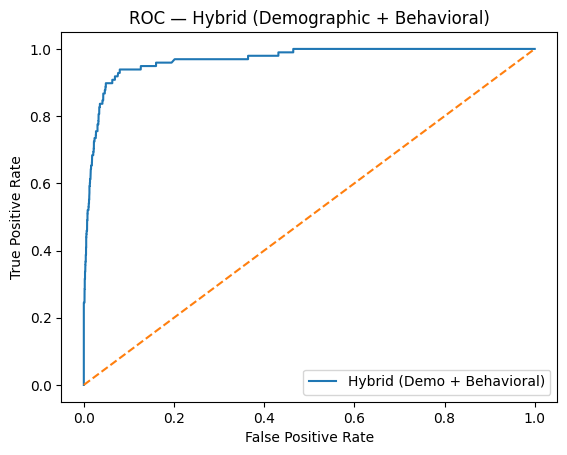


===== Hybrid (Logistic) — Classification Report =====
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5307
           1       0.24      0.90      0.38        98

    accuracy                           0.95      5405
   macro avg       0.62      0.92      0.68      5405
weighted avg       0.98      0.95      0.96      5405



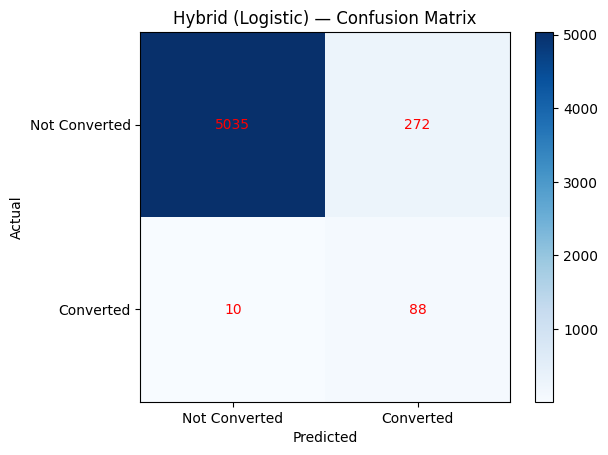

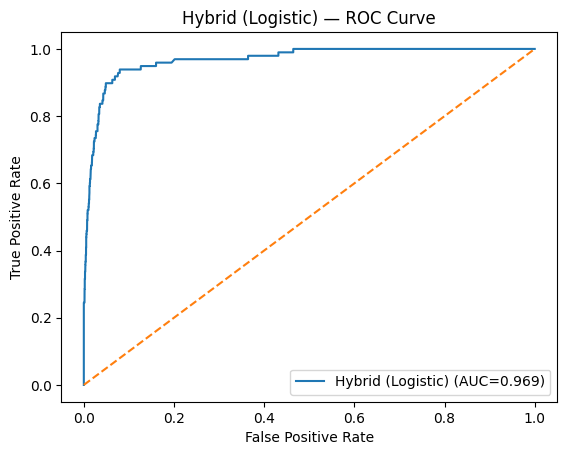

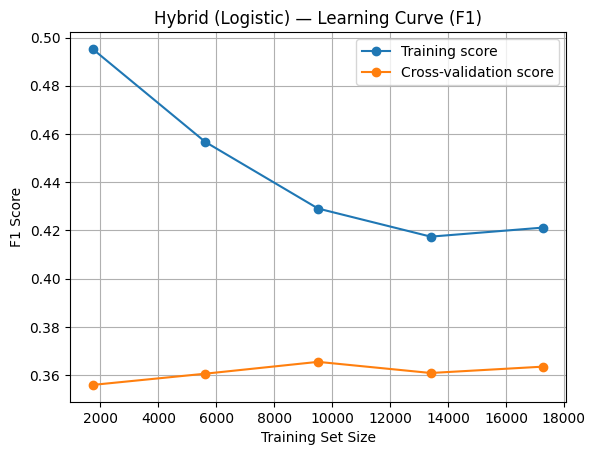

In [36]:
# 11) Hybrid model (Demographic + Behavioral) — Logistic + full evaluation

# Rebuild demo feature list from cleaned names
demo_features = num_features + [c for c in cat_features_use if c in abt.columns]

# Ensure behavioral column is present
has_behavioral_now = ('BEHAVIORAL_SCORE_COL' in globals()
                      and BEHAVIORAL_SCORE_COL is not None
                      and BEHAVIORAL_SCORE_COL in abt.columns)

if has_behavioral_now:
    # Build X with demo + behavioral
    X_hybrid = abt[demo_features + [BEHAVIORAL_SCORE_COL]].copy()
    X_hybrid[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_hybrid[BEHAVIORAL_SCORE_COL], errors="coerce")

    X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(
        X_hybrid, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # Preprocessor: numeric = num_features + behavioral; categorical = cat_features_use
    hybrid_num = [c for c in num_features if c in X_h_train.columns] + [BEHAVIORAL_SCORE_COL]
    hybrid_cat = [c for c in cat_features_use if c in X_h_train.columns]

    hybrid_preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, hybrid_num),
            ("cat", categorical_transformer, hybrid_cat),
        ]
    )

    hybrid_pipe = Pipeline(steps=[
        ("prep", hybrid_preprocessor),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
    ])

    # Fit + evaluate
    hybrid_pipe.fit(X_h_train, y_h_train)
    hyb_proba = hybrid_pipe.predict_proba(X_h_test)[:, 1]
    hyb_preds = (hyb_proba >= 0.50).astype(int)

    print("Hybrid Accuracy:", accuracy_score(y_h_test, hyb_preds))
    print("Hybrid Precision:", precision_score(y_h_test, hyb_preds, zero_division=0))
    print("Hybrid Recall:", recall_score(y_h_test, hyb_preds, zero_division=0))
    print("Hybrid F1:", f1_score(y_h_test, hyb_preds, zero_division=0))
    print("Hybrid AUC:", roc_auc_score(y_h_test, hyb_proba))

    # ROC
    fpr, tpr, _ = roc_curve(y_h_test, hyb_proba)
    plt.figure()
    plt.plot(fpr, tpr, label="Hybrid (Demo + Behavioral)")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — Hybrid (Demographic + Behavioral)")
    plt.legend(); plt.show()

    # (Optional) detailed plots you already use
    evaluate_detailed(hybrid_pipe, X_h_train, y_h_train, X_h_test, y_h_test,
                      model_name="Hybrid (Logistic)")

else:
    print("Behavioral score not available; skipping hybrid section.")


# Hybrid XGBoost (weighted)

Hybrid XGB Accuracy: 0.9635522664199815
Hybrid XGB Precision: 0.2962962962962963
Hybrid XGB Recall: 0.7346938775510204
Hybrid XGB F1: 0.4222873900293255
Hybrid XGB AUC: 0.9710124863964805

===== Hybrid XGBoost (weighted) — Classification Report =====
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5307
           1       0.30      0.73      0.42        98

    accuracy                           0.96      5405
   macro avg       0.65      0.85      0.70      5405
weighted avg       0.98      0.96      0.97      5405



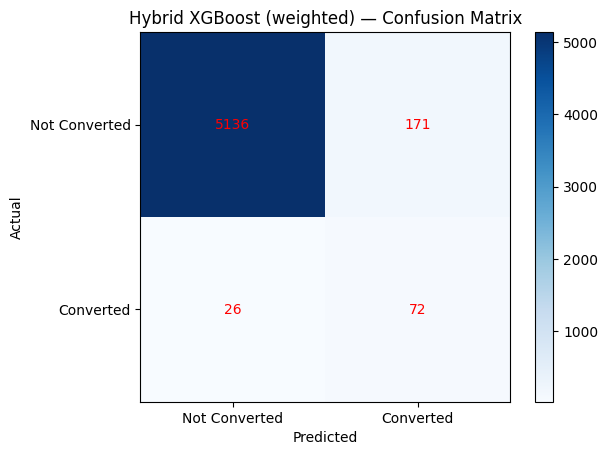

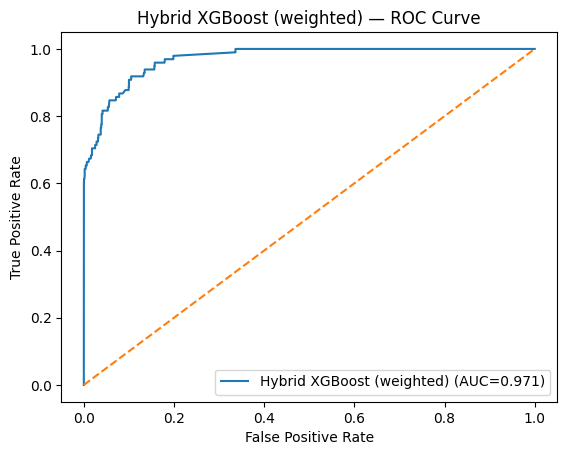

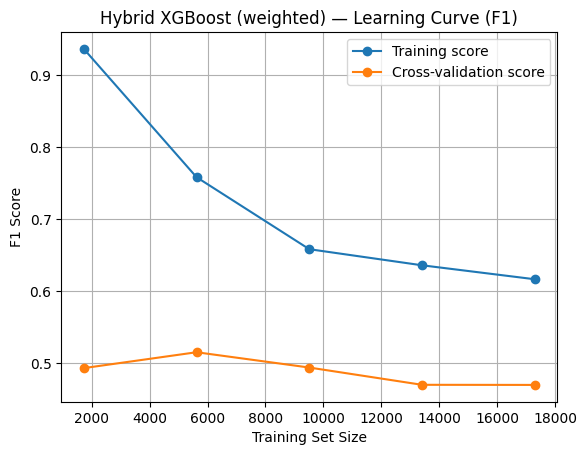

In [37]:
# Hybrid XGBoost (weighted)

if has_behavioral_now:
    # Build X with demo + behavioral
    X_hybrid = abt[demo_features + [BEHAVIORAL_SCORE_COL]].copy()
    X_hybrid[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_hybrid[BEHAVIORAL_SCORE_COL], errors="coerce")

    Xh_train, Xh_test, yh_train, yh_test = train_test_split(
        X_hybrid, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # Preprocessor
    hybrid_num = [c for c in num_features if c in Xh_train.columns] + [BEHAVIORAL_SCORE_COL]
    hybrid_cat = [c for c in cat_features_use if c in Xh_train.columns]

    hybrid_preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, hybrid_num),
            ("cat", categorical_transformer, hybrid_cat)
        ]
    )

    # imbalance ratio
    spw = float((yh_train == 0).sum()) / float((yh_train == 1).sum())

    xgb_hybrid_pipe = Pipeline(steps=[
        ("prep", hybrid_preprocessor),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=RANDOM_STATE,
            n_estimators=600,
            scale_pos_weight=spw,
            n_jobs=-1
        ))
    ])

    xgb_hybrid_pipe.fit(Xh_train, yh_train)
    xgb_hyb_proba = xgb_hybrid_pipe.predict_proba(Xh_test)[:,1]
    xgb_hyb_preds = (xgb_hyb_proba >= 0.5).astype(int)

    print("Hybrid XGB Accuracy:", accuracy_score(yh_test, xgb_hyb_preds))
    print("Hybrid XGB Precision:", precision_score(yh_test, xgb_hyb_preds, zero_division=0))
    print("Hybrid XGB Recall:", recall_score(yh_test, xgb_hyb_preds, zero_division=0))
    print("Hybrid XGB F1:", f1_score(yh_test, xgb_hyb_preds, zero_division=0))
    print("Hybrid XGB AUC:", roc_auc_score(yh_test, xgb_hyb_proba))

    evaluate_detailed(xgb_hybrid_pipe, Xh_train, yh_train, Xh_test, yh_test,
                      model_name="Hybrid XGBoost (weighted)")


# Hybrid LightGBM (Weighted)

[LightGBM] [Info] Number of positive: 391, number of negative: 21228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 21619, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Hybrid LGBM Accuracy: 0.969472710453284
Hybrid LGBM Precision: 0.3333333333333333
Hybrid LGBM Recall: 0.6836734693877551
Hybrid LGBM F1: 0.44816053511705684
Hybrid LGBM AUC: 0.9676688086201127

===== Hybrid LightGBM (weighted) — Classification Report =====
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5307
           1       0.33      0.68      0.45        98

    accuracy             

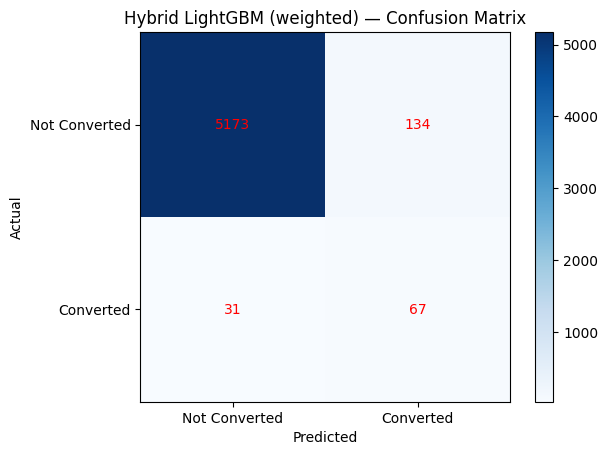

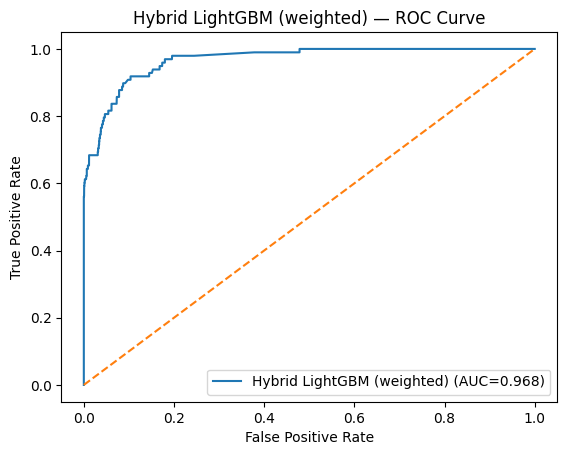

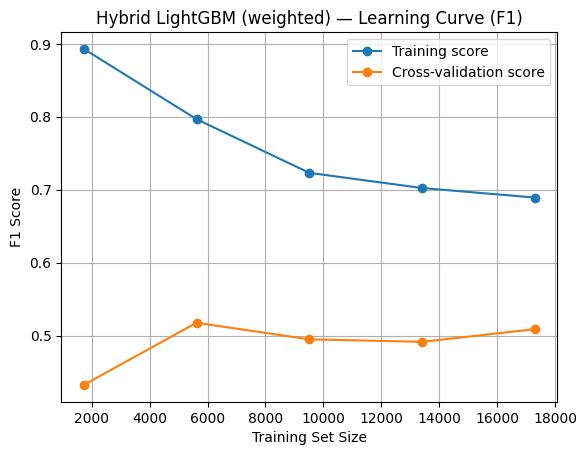

In [38]:
# Hybrid LightGBM (weighted)

from lightgbm import LGBMClassifier

if has_behavioral_now:
    # Build X with demo + behavioral
    X_hybrid = abt[demo_features + [BEHAVIORAL_SCORE_COL]].copy()
    X_hybrid[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_hybrid[BEHAVIORAL_SCORE_COL], errors="coerce")

    Xh_train, Xh_test, yh_train, yh_test = train_test_split(
        X_hybrid, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # Preprocessor
    hybrid_num = [c for c in num_features if c in Xh_train.columns] + [BEHAVIORAL_SCORE_COL]
    hybrid_cat = [c for c in cat_features_use if c in Xh_train.columns]

    hybrid_preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, hybrid_num),
            ("cat", categorical_transformer, hybrid_cat)
        ]
    )

    # imbalance ratio
    spw = float((yh_train == 0).sum()) / float((yh_train == 1).sum())

    lgbm_hybrid_pipe = Pipeline(steps=[
        ("prep", hybrid_preprocessor),
        ("clf", LGBMClassifier(
            objective="binary",
            n_estimators=600,
            random_state=RANDOM_STATE,
            class_weight={0:1, 1:spw},  # weighted
            n_jobs=-1
        ))
    ])

    lgbm_hybrid_pipe.fit(Xh_train, yh_train)
    lgbm_hyb_proba = lgbm_hybrid_pipe.predict_proba(Xh_test)[:,1]
    lgbm_hyb_preds = (lgbm_hyb_proba >= 0.5).astype(int)

    print("Hybrid LGBM Accuracy:", accuracy_score(yh_test, lgbm_hyb_preds))
    print("Hybrid LGBM Precision:", precision_score(yh_test, lgbm_hyb_preds, zero_division=0))
    print("Hybrid LGBM Recall:", recall_score(yh_test, lgbm_hyb_preds, zero_division=0))
    print("Hybrid LGBM F1:", f1_score(yh_test, lgbm_hyb_preds, zero_division=0))
    print("Hybrid LGBM AUC:", roc_auc_score(yh_test, lgbm_hyb_proba))

    evaluate_detailed(lgbm_hybrid_pipe, Xh_train, yh_train, Xh_test, yh_test,
                      model_name="Hybrid LightGBM (weighted)")


# 12A) Pick the model output to tune (auto-detect)

In [39]:
# 12A) Select the model outputs to tune (auto)
from sklearn.metrics import roc_auc_score

candidates = []

# Hybrid Logistic
if 'y_h_test' in globals() and 'hyb_proba' in globals():
    candidates.append(("Hybrid Logistic", y_h_test, hyb_proba))

# Hybrid XGBoost
if 'yh_test' in globals() and 'xgb_hyb_proba' in globals():
    candidates.append(("Hybrid XGBoost (weighted)", yh_test, xgb_hyb_proba))

# Hybrid LightGBM
if 'yh_test' in globals() and 'lgbm_hyb_proba' in globals():
    candidates.append(("Hybrid LightGBM (weighted)", yh_test, lgbm_hyb_proba))

assert candidates, "No (y_true, proba) found. Run a hybrid model first."

# pick the one with best AUC by default; change 'best' index if you want a specific one
best = max(candidates, key=lambda t: roc_auc_score(t[1], t[2]))
MODEL_NAME, y_true, proba = best
print("Tuning thresholds for:", MODEL_NAME, "| AUC =", roc_auc_score(y_true, proba))


Tuning thresholds for: Hybrid XGBoost (weighted) | AUC = 0.9710124863964805


# 12B) Precision–Recall vs Threshold + best cutoffs

Hybrid XGBoost (weighted) — best F1 threshold: 0.9918
Hybrid XGBoost (weighted) — threshold for recall>=0.85: 0.0119
Hybrid XGBoost (weighted) — threshold for precision>=0.3: 1.0000


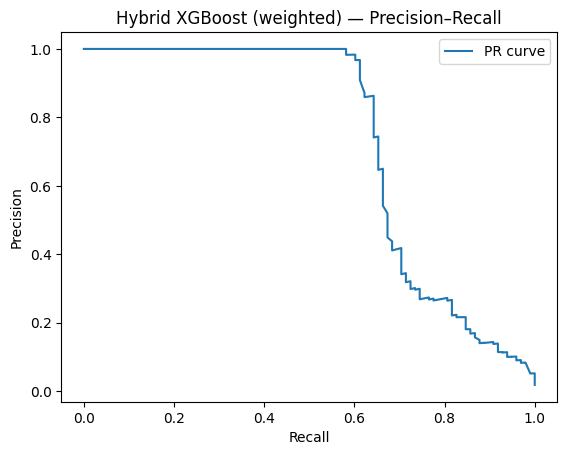

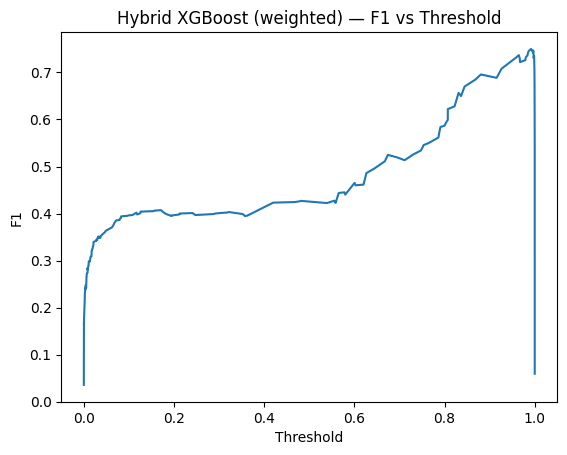

In [40]:
# 12B) PR-threshold analysis: best F1, target-recall, target-precision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, classification_report

prec, rec, thr = precision_recall_curve(y_true, proba)
# thresholds have length len(prec)-1
f1 = 2*prec*rec/(prec+rec+1e-9)
f1_thr = thr[np.argmax(f1[:-1])]  # best-F1 threshold

# choose business targets (adjust if you like)
TARGET_RECALL = 0.85
TARGET_PREC  = 0.30

# threshold that achieves at least target recall (highest threshold with recall >= target)
idx_rec = np.where(rec[:-1] >= TARGET_RECALL)[0]
thr_rec = thr[idx_rec[-1]] if len(idx_rec) else thr[0]

# threshold that achieves at least target precision (highest precision)
idx_prec = np.where(prec[:-1] >= TARGET_PREC)[0]
thr_prec = thr[idx_prec[-1]] if len(idx_prec) else thr[-1]

print(f"{MODEL_NAME} — best F1 threshold: {f1_thr:.4f}")
print(f"{MODEL_NAME} — threshold for recall>={TARGET_RECALL}: {thr_rec:.4f}")
print(f"{MODEL_NAME} — threshold for precision>={TARGET_PREC}: {thr_prec:.4f}")

# Plot PR curve
plt.figure()
plt.plot(rec, prec, label="PR curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"{MODEL_NAME} — Precision–Recall")
plt.legend(); plt.show()

# Plot F1 vs threshold
plt.figure()
plt.plot(thr, f1[:-1])
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.title(f"{MODEL_NAME} — F1 vs Threshold")
plt.show()


# 12C) Metrics & confusion matrix at chosen thresholds


Best-F1 @ threshold=0.9918  |  Precision=0.968  Recall=0.612  F1=0.750
[[5305    2]
 [  38   60]]


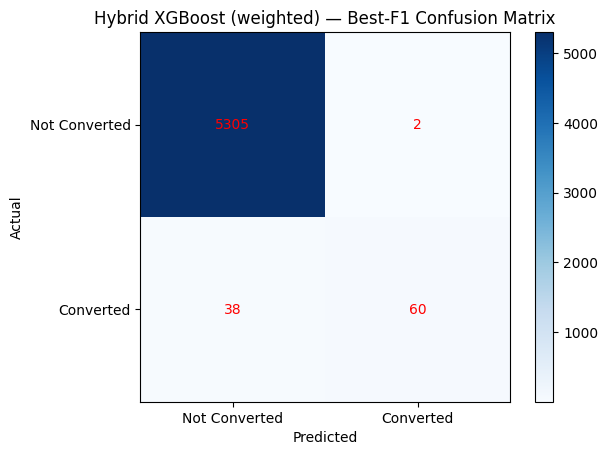


Recall>=0.85 @ threshold=0.0119  |  Precision=0.181  Recall=0.857  F1=0.299
[[4927  380]
 [  14   84]]


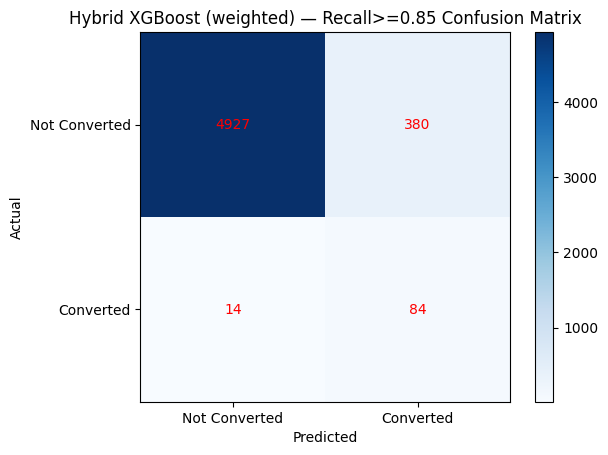


Precision>=0.3 @ threshold=1.0000  |  Precision=1.000  Recall=0.031  F1=0.059
[[5307    0]
 [  95    3]]


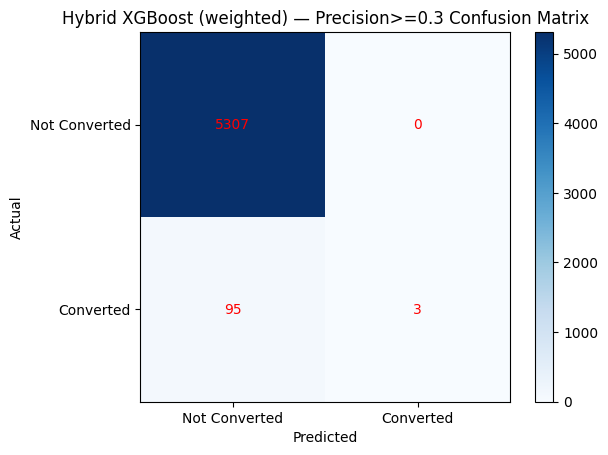

In [41]:
def eval_at_threshold(th, name):
    y_pred = (proba >= th).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    P  = precision_score(y_true, y_pred, zero_division=0)
    R  = recall_score(y_true, y_pred, zero_division=0)
    F1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{name} @ threshold={th:.4f}  |  Precision={P:.3f}  Recall={R:.3f}  F1={F1:.3f}")
    print(cm)
    # pretty plot
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{MODEL_NAME} — {name} Confusion Matrix")
    plt.colorbar()
    plt.xticks([0,1], ["Not Converted","Converted"])
    plt.yticks([0,1], ["Not Converted","Converted"])
    for i in range(2):
        for j in range(2):
            plt.text(j,i, cm[i,j], ha="center", va="center", color="red")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

eval_at_threshold(f1_thr,  "Best-F1")
eval_at_threshold(thr_rec, f"Recall>={TARGET_RECALL}")
eval_at_threshold(thr_prec, f"Precision>={TARGET_PREC}")


# 12D) Lift & Cumulative Gain (Deciles) + Top-K capture

Overall conversion rate: 0.0181


,decile,leads,positives,conv_rate,lift,cum_positives,cum_capture
0,0,541,85,0.157116,8.665453,85,0.867347
1,1,540,10,0.018519,1.021353,95,0.969388
2,2,541,1,0.001848,0.101947,96,0.979592
3,3,540,2,0.003704,0.204271,98,1.000000
4,4,541,0,0.000000,0.000000,98,1.000000
5,5,540,0,0.000000,0.000000,98,1.000000
6,6,540,0,0.000000,0.000000,98,1.000000
7,7,541,0,0.000000,0.000000,98,1.000000
8,8,540,0,0.000000,0.000000,98,1.000000
9,9,541,0,0.000000,0.000000,98,1.000000


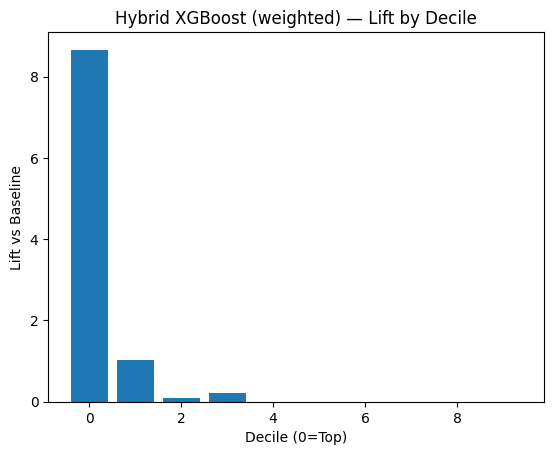

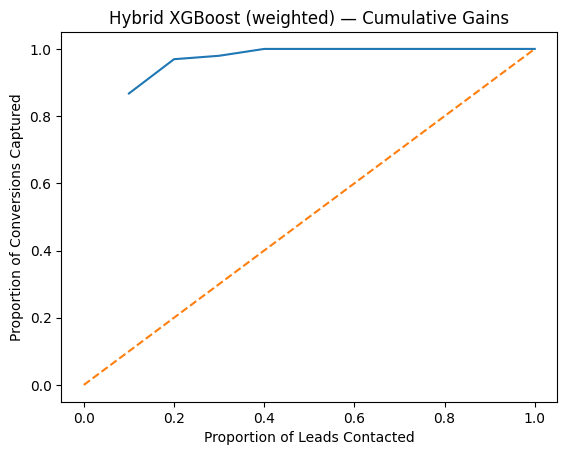

Top 10% capture=86.73%, precision=15.74%
Top 20% capture=96.94%, precision=8.79%


In [42]:
# 12D) Lift chart & cumulative gains, plus top-k capture
import pandas as pd
n = len(proba)
df = pd.DataFrame({"y": y_true, "p": proba}).sort_values("p", ascending=False).reset_index(drop=True)

# deciles (10 bins of equal count)
df["decile"] = pd.qcut(df.index+1, 10, labels=False)

# conversion rate per decile & baseline
overall_rate = df["y"].mean()
by_decile = df.groupby("decile").agg(
    leads=("y","size"),
    positives=("y","sum"),
    conv_rate=("y","mean")
).reset_index()
by_decile["lift"] = by_decile["conv_rate"] / overall_rate

# cumulative capture of positives
by_decile["cum_positives"] = by_decile["positives"].cumsum()
by_decile["cum_capture"] = by_decile["cum_positives"] / by_decile["positives"].sum()

print("Overall conversion rate:", round(overall_rate,4))
display(by_decile)

# Lift bar
plt.figure()
plt.bar(by_decile["decile"], by_decile["lift"])
plt.xlabel("Decile (0=Top)"); plt.ylabel("Lift vs Baseline")
plt.title(f"{MODEL_NAME} — Lift by Decile")
plt.show()

# Cumulative gains
plt.figure()
plt.plot((by_decile["decile"]+1)/10.0, by_decile["cum_capture"])
plt.plot([0,1],[0,1],'--')
plt.xlabel("Proportion of Leads Contacted")
plt.ylabel("Proportion of Conversions Captured")
plt.title(f"{MODEL_NAME} — Cumulative Gains")
plt.show()

# Top 10% / 20% capture and precision
k10 = int(0.10*n); k20 = int(0.20*n)
top10 = df.iloc[:k10]; top20 = df.iloc[:k20]
cap10 = top10["y"].sum()/df["y"].sum()
cap20 = top20["y"].sum()/df["y"].sum()
prec10 = top10["y"].mean()
prec20 = top20["y"].mean()
print(f"Top 10% capture={cap10:.2%}, precision={prec10:.2%}")
print(f"Top 20% capture={cap20:.2%}, precision={prec20:.2%}")


# 12E) Make band thresholds you can reuse in Step 12 (Very High / High / Medium / Low)

In [43]:
# 12E) Band thresholds (quantile-based) + helper for later scoring
# Choose quantiles (edit if your ops want different sizes)
q_vhigh, q_high, q_med = 0.90, 0.70, 0.50

t_vhigh = np.quantile(proba, q_vhigh)
t_high  = np.quantile(proba, q_high)
t_med   = np.quantile(proba, q_med)

print("Band thresholds (on validation/test):",
      f"VeryHigh≥{t_vhigh:.4f}  High≥{t_high:.4f}  Medium≥{t_med:.4f}  else Low")

def bander(p):
    if p >= t_vhigh: return "Very High"
    if p >= t_high:  return "High"
    if p >= t_med:   return "Medium"
    return "Low"


Band thresholds (on validation/test): VeryHigh≥0.0058  High≥0.0001  Medium≥0.0000  else Low


# 12F) Profit Curve — pick the money-optimal threshold

What it does: for many thresholds it computes:

Contacts made

Conversions predicted correctly

Expected profit = (TP × value_per_conversion) − (contacts × cost_per_contact)
…and picks the best threshold.

⚠️ Set the two business numbers first.

Best-profit threshold: 0.0
Contacts: 5405 | TP (conversions): 98 | Profit: 38,695,000


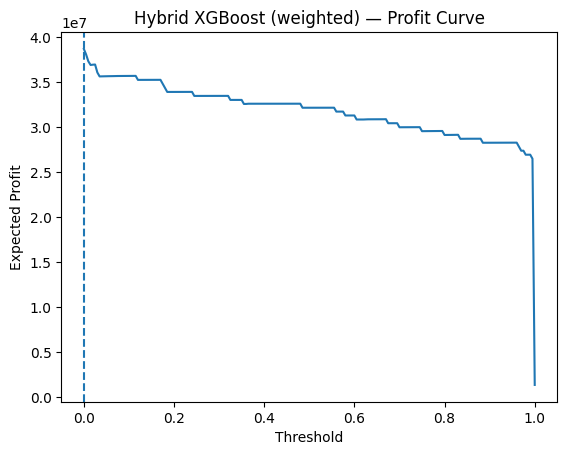

,threshold,contacts,tp,fp,profit
0,0.000,5405,98,5307,38695000
1,0.005,613,86,527,38087000
2,0.010,483,84,399,37317000
3,0.015,441,83,358,36909000
4,0.020,407,83,324,36943000
5,0.025,389,83,306,36961000


In [46]:
# ===== 12F) Profit curve (business-optimal threshold) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 1) Set business values (EDIT THESE) ---
value_per_conversion = 450000   # INR (example) revenue/GM per enrollment
cost_per_contact     = 1000     # INR cost to call/email/engage one lead

# --- 2) Build a grid of thresholds ---
ths = np.linspace(0.0, 1.0, 201)

rows = []
P = (y_true == 1).sum()
N = (y_true == 0).sum()

for th in ths:
    pred = (proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    contacts = (pred == 1).sum()                 # how many we would contact
    revenue  = tp * value_per_conversion
    cost     = contacts * cost_per_contact
    profit   = revenue - cost
    rows.append([th, tp, fp, fn, tn, contacts, revenue, cost, profit])

prof = pd.DataFrame(rows, columns=[
    "threshold","tp","fp","fn","tn","contacts","revenue","cost","profit"
])

best_ix = prof["profit"].idxmax()
best_row = prof.loc[best_ix]
print("Best-profit threshold:", round(best_row.threshold, 4))
print("Contacts:", int(best_row.contacts),
      "| TP (conversions):", int(best_row.tp),
      "| Profit:", f"{best_row.profit:,.0f}")

plt.figure()
plt.plot(prof["threshold"], prof["profit"])
plt.axvline(best_row.threshold, linestyle="--")
plt.xlabel("Threshold"); plt.ylabel("Expected Profit")
plt.title(f"{MODEL_NAME} — Profit Curve")
plt.show()

# Quick table around the optimum to show trade-offs
display(prof.loc[max(0,best_ix-5):best_ix+5]
        [["threshold","contacts","tp","fp","profit"]]
        .sort_values("threshold"))


# 12G) Profit @ Top-K% targeting (no fixed threshold)

Sometimes marketing works by taking the top 10% or 20% leads. This computes profit for those policies.

In [47]:
# ===== 12G) Profit if we contact top K% of leads =====
# Uses the same business values set above.
df_rank = pd.DataFrame({"y": y_true, "p": proba}).sort_values("p", ascending=False).reset_index(drop=True)

for k in [0.05, 0.10, 0.20, 0.30]:
    kN = int(len(df_rank)*k)
    topk = df_rank.iloc[:kN]
    tp   = topk["y"].sum()
    contacts = kN
    revenue  = tp * value_per_conversion
    cost     = contacts * cost_per_contact
    profit   = revenue - cost
    print(f"Top {int(k*100)}%  | contacts={contacts}  tp={tp}  profit={profit:,.0f}")


Top 5%  | contacts=270  tp=73  profit=32,580,000
Top 10%  | contacts=540  tp=85  profit=37,710,000
Top 20%  | contacts=1081  tp=95  profit=41,669,000
Top 30%  | contacts=1621  tp=96  profit=41,579,000


# 12H) Feature importance (for your chosen hybrid model)

Works for Logistic (coeffs) and tree models (XGB/LGBM feature_importances_).
Paste this once; then call it with your fitted pipeline (e.g., xgb_hybrid_pipe or lgbm_hybrid_pipe).

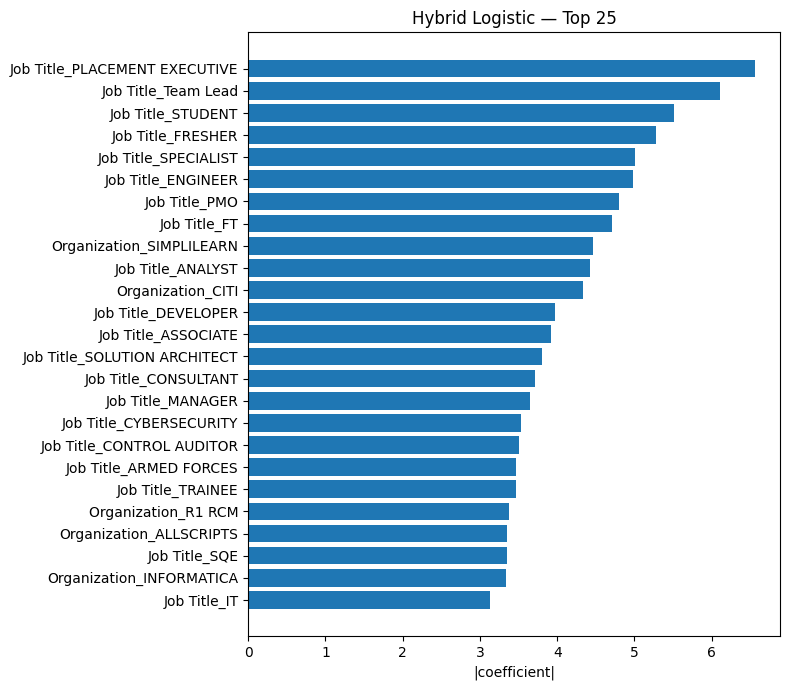

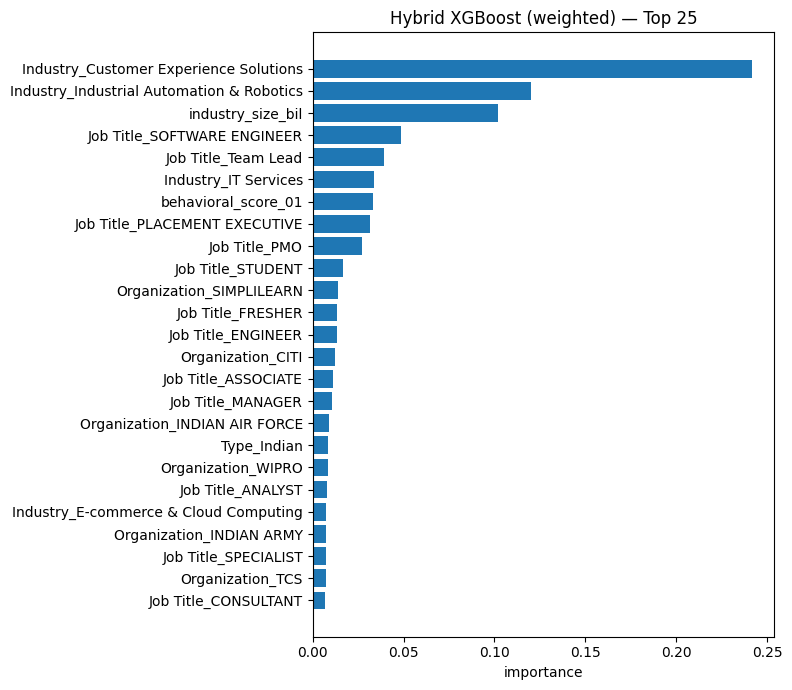

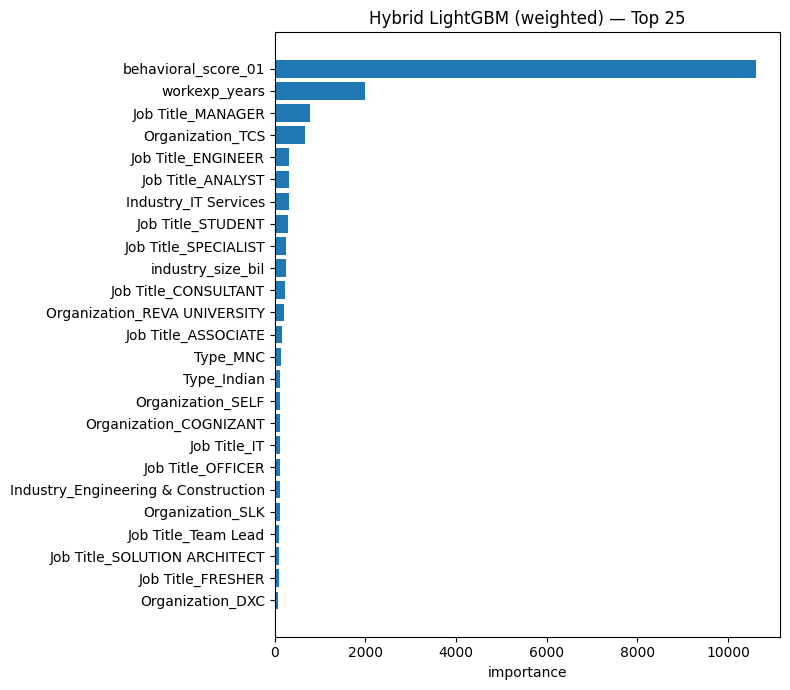

,feature,value
2,behavioral_score_01,10619
0,workexp_years,1990
3062,Job Title_MANAGER,778
13806,Organization_TCS,671
1804,Job Title_ENGINEER,323
...,...,...
14899,Organization_ZOLT INFO SOLUTION PRIVATE LIMITED,0
14900,Organization_ZOMATO,0
14901,Organization_ZONES CORPORATE SOLUTIONS,0
14902,Organization_ZONTA INFRATECH,0


In [49]:
# === 12H) Feature Importance (works for Logistic / XGB / LGBM) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def get_feature_names_for(preprocessor):
    # numeric names
    num_cols = preprocessor.transformers_[0][2]
    # OneHot names
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_input = preprocessor.transformers_[1][2]
    cat_names = list(ohe.get_feature_names_out(cat_input))
    return list(num_cols) + cat_names

def plot_feature_importance_from_pipe(fitted_pipe, title="Feature Importance", top_k=25):
    prep = fitted_pipe.named_steps["prep"]
    clf  = fitted_pipe.named_steps["clf"]
    names = get_feature_names_for(prep)

    if hasattr(clf, "feature_importances_"):
        vals = clf.feature_importances_
        label = "importance"
    elif hasattr(clf, "coef_"):
        vals = np.abs(clf.coef_.ravel())
        label = "|coefficient|"
    else:
        raise ValueError("Model has neither feature_importances_ nor coef_.")
    
    df_imp = pd.DataFrame({"feature": names, "value": vals}).sort_values("value", ascending=False)
    top = df_imp.head(top_k)

    plt.figure(figsize=(8, 7))
    y = np.arange(len(top))
    plt.barh(y, top["value"])
    plt.yticks(y, top["feature"])
    plt.gca().invert_yaxis()
    plt.xlabel(label); plt.title(f"{title} — Top {top_k}")
    plt.tight_layout(); plt.show()
    return df_imp

# EXAMPLES (run one or all, depending on what you trained)
plot_feature_importance_from_pipe(hybrid_pipe, "Hybrid Logistic")
plot_feature_importance_from_pipe(xgb_hybrid_pipe, "Hybrid XGBoost (weighted)")
plot_feature_importance_from_pipe(lgbm_hybrid_pipe, "Hybrid LightGBM (weighted)")


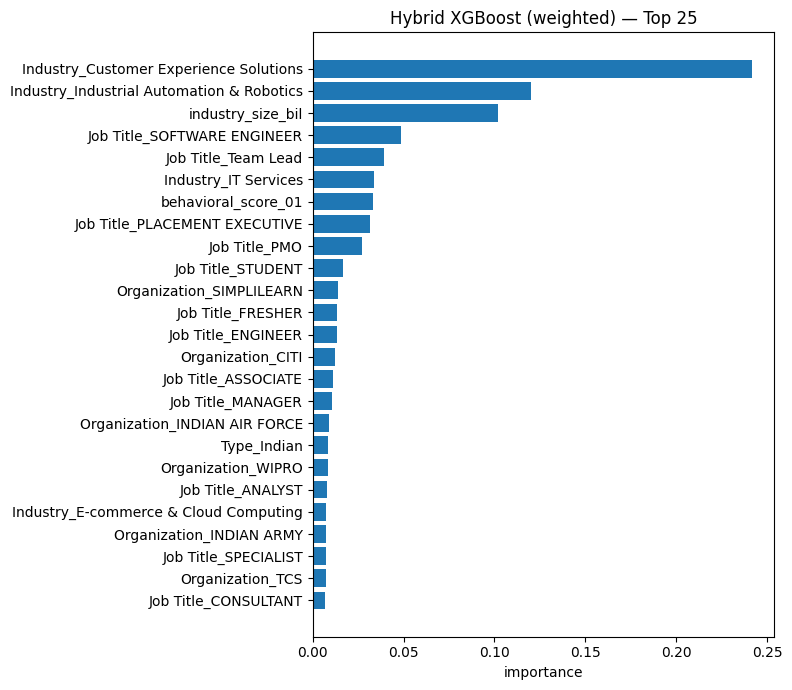

In [50]:
imp_xgb = plot_feature_importance_from_pipe(xgb_hybrid_pipe, "Hybrid XGBoost (weighted)")
imp_xgb.to_csv("feature_importance_hybrid_xgb.csv", index=False)

In [51]:
# Map model name -> fitted pipeline object (adjust based on what you ran)
model_map = {
    "Hybrid Logistic": hybrid_pipe if 'hybrid_pipe' in globals() else None,
    "Hybrid XGBoost (weighted)": xgb_hybrid_pipe if 'xgb_hybrid_pipe' in globals() else None,
    "Hybrid LightGBM (weighted)": lgbm_hybrid_pipe if 'lgbm_hybrid_pipe' in globals() else None,
}
best_pipe = model_map.get(MODEL_NAME)
assert best_pipe is not None, f"Couldn't match MODEL_NAME={MODEL_NAME} to a pipeline. Check model_map."
print("Best model selected for scoring/export:", MODEL_NAME)


Best model selected for scoring/export: Hybrid XGBoost (weighted)


# Export ALL leads with probability bands

In [54]:
!pip install xlsxwriter


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
# === 12I – Export ALL leads with probability bands (and summary) ===
import numpy as np, pandas as pd, pickle

# 0) Choose which fitted hybrid pipeline to use
#    (Make sure one of these exists from earlier steps.)
model_map = {
    "Hybrid Logistic": globals().get("hybrid_pipe"),
    "Hybrid XGBoost (weighted)": globals().get("xgb_hybrid_pipe"),
    "Hybrid LightGBM (weighted)": globals().get("lgbm_hybrid_pipe"),
}
best_pipe = model_map.get(MODEL_NAME)
assert best_pipe is not None, "Could not resolve best model pipeline; check MODEL_NAME and model_map."

# 1) Columns to score (hybrid = demo + behavioral)
use_cols = demo_features + [BEHAVIORAL_SCORE_COL]
X_all = abt[use_cols].copy()
X_all[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_all[BEHAVIORAL_SCORE_COL], errors="coerce")

# 2) Optional: refit on ALL data for final scoring (or comment this if you prefer the trained split model)
best_pipe.fit(X_all, y)

# 3) Score all leads
all_proba = best_pipe.predict_proba(X_all)[:, 1]
scored = abt.copy()
scored["pred_proba"] = all_proba

# 4) Rank & deciles (for analysis; not required for bands but useful)
scored = scored.sort_values("pred_proba", ascending=False).reset_index(drop=True)
scored["rank"] = np.arange(1, len(scored) + 1)
# decile 0 = top 10%
scored["decile"] = pd.qcut(scored["rank"], 10, labels=False)

# 5) Band thresholds
#    Use your previously computed thresholds if available; else compute on current scores.
if "t_vhigh" not in globals() or "t_high" not in globals() or "t_med" not in globals():
    q_vhigh, q_high, q_med = 0.90, 0.70, 0.50
    t_vhigh = float(np.quantile(all_proba, q_vhigh))
    t_high  = float(np.quantile(all_proba, q_high))
    t_med   = float(np.quantile(all_proba, q_med))

def bander(p):
    if p >= t_vhigh: return "Very High"
    if p >= t_high:  return "High"
    if p >= t_med:   return "Medium"
    return "Low"

scored["band"] = scored["pred_proba"].apply(bander)

# 6) Summary table (counts, avg prob, expected conversions = sum of probabilities)
band_summary = (scored
    .groupby("band", as_index=False)
    .agg(
        leads=("pred_proba", "size"),
        avg_proba=("pred_proba", "mean"),
        expected_conversions=("pred_proba", "sum"),
    )
    .sort_values("avg_proba", ascending=False)
)
band_summary["avg_proba"] = band_summary["avg_proba"].round(4)
band_summary["expected_conversions"] = band_summary["expected_conversions"].round(1)

print("Band thresholds:")
print(f"  Very High ≥ {t_vhigh:.6f}")
print(f"  High      ≥ {t_high:.6f}")
print(f"  Medium    ≥ {t_med:.6f}  else Low")

# 7) Export to Excel — all rows + one sheet per band + summary
out_path = "capstone2_scored_bands.xlsx"
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    scored.to_excel(writer, index=False, sheet_name="All_scored")
    band_summary.to_excel(writer, index=False, sheet_name="Band_Summary")
    for b in ["Very High", "High", "Medium", "Low"]:
        scored.loc[scored["band"] == b].to_excel(writer, index=False, sheet_name=b)

# 8) Save the model artifact for reuse
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_pipe, f)

print(f"Saved: {out_path} (All_scored + bands + summary) and best_model.pkl")


Band thresholds:
  Very High ≥ 0.005772
  High      ≥ 0.000115
  Medium    ≥ 0.000004  else Low
Saved: capstone2_scored_bands.xlsx (All_scored + bands + summary) and best_model.pkl


In [56]:
# === 12I) Score ALL leads and export Top-K% + Bands ===
import pandas as pd, numpy as np, pickle

# 1) Choose features for the chosen best model (hybrid uses demo + behavioral)
use_cols = demo_features + [BEHAVIORAL_SCORE_COL]
X_all = abt[use_cols].copy()
X_all[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_all[BEHAVIORAL_SCORE_COL], errors="coerce")

# 2) (Optional) refit best model on ALL data for final scoring
best_pipe.fit(X_all, y)

# 3) Predict probabilities on all leads
all_proba = best_pipe.predict_proba(X_all)[:,1]
scored = abt.copy()
scored["pred_proba"] = all_proba

# 4) Rank + Top-K masks
scored = scored.sort_values("pred_proba", ascending=False).reset_index(drop=True)
n = len(scored)
k10 = int(0.10*n); k20 = int(0.20*n)
scored["rank"] = np.arange(1, n+1)
scored["top10_flag"] = scored["rank"] <= k10
scored["top20_flag"] = scored["rank"] <= k20

# 5) Bands (using thresholds from 12E)
def bander(p):
    if p >= t_vhigh: return "Very High"
    if p >= t_high:  return "High"
    if p >= t_med:   return "Medium"
    return "Low"
scored["band"] = scored["pred_proba"].apply(bander)

# 6) Export
with pd.ExcelWriter("capstone2_scored_outputs.xlsx", engine="xlsxwriter") as writer:
    scored.to_excel(writer, index=False, sheet_name="All_scored")
    scored.loc[scored["top10_flag"]].to_excel(writer, index=False, sheet_name="Top10pct")
    scored.loc[scored["top20_flag"]].to_excel(writer, index=False, sheet_name="Top20pct")
    for b in ["Very High","High","Medium","Low"]:
        scored.loc[scored["band"]==b].to_excel(writer, index=False, sheet_name=b)

# 7) Save model artifact
with open("best_model.pkl","wb") as f:
    pickle.dump(best_pipe, f)

print("Saved: capstone2_scored_outputs.xlsx (All, Top10, Top20, Bands) and best_model.pkl")


Saved: capstone2_scored_outputs.xlsx (All, Top10, Top20, Bands) and best_model.pkl


In [57]:
# =======================
# STEP 13 — FINAL EXPORT
# =======================
import numpy as np, pandas as pd, pickle

# 0) Choose the model to export with (you already selected this via MODEL_NAME)
model_map = {
    "Hybrid Logistic": globals().get("hybrid_pipe"),
    "Hybrid XGBoost (weighted)": globals().get("xgb_hybrid_pipe"),
    "Hybrid LightGBM (weighted)": globals().get("lgbm_hybrid_pipe"),
}
best_pipe = model_map.get(MODEL_NAME)
assert best_pipe is not None, f"MODEL_NAME={MODEL_NAME} not mapped to a fitted pipeline."

# 1) Build feature matrix for the hybrid model (demo + behavioral)
use_cols = demo_features + [BEHAVIORAL_SCORE_COL]
X_all = abt[use_cols].copy()
X_all[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_all[BEHAVIORAL_SCORE_COL], errors="coerce")

# 2) (Recommended) Refit on ALL labeled data
best_pipe.fit(X_all, y)

# 3) Predict probability for EVERY lead
all_proba = best_pipe.predict_proba(X_all)[:, 1]
scored = abt.copy()
scored["pred_proba"] = all_proba

# 4) Rank & decile
scored = scored.sort_values("pred_proba", ascending=False).reset_index(drop=True)
scored["rank"] = np.arange(1, len(scored) + 1)
scored["decile"] = pd.qcut(scored["rank"], 10, labels=False)  # 0=top decile

# 5) Probability bands (use existing thresholds if defined; else compute)
if not all(k in globals() for k in ["t_vhigh", "t_high", "t_med"]):
    q_vhigh, q_high, q_med = 0.90, 0.70, 0.50
    t_vhigh = float(np.quantile(all_proba, q_vhigh))
    t_high  = float(np.quantile(all_proba, q_high))
    t_med   = float(np.quantile(all_proba, q_med))

def bander(p):
    if p >= t_vhigh: return "Very High"
    if p >= t_high:  return "High"
    if p >= t_med:   return "Medium"
    return "Low"

scored["band"] = scored["pred_proba"].apply(bander)

# 6) OPTIONAL: also mark Top-10% / Top-20% for operational campaigns
n = len(scored)
k10 = int(0.10*n); k20 = int(0.20*n)
scored["top10_flag"] = scored["rank"] <= k10
scored["top20_flag"] = scored["rank"] <= k20

# 7) Band summary (great for PPT)
band_summary = (scored.groupby("band", as_index=False)
                .agg(leads=("pred_proba","size"),
                     avg_proba=("pred_proba","mean"),
                     expected_conversions=("pred_proba","sum"))
                .sort_values("avg_proba", ascending=False))
band_summary["avg_proba"] = band_summary["avg_proba"].round(4)
band_summary["expected_conversions"] = band_summary["expected_conversions"].round(1)

print("Band thresholds:")
print(f"  Very High ≥ {t_vhigh:.6f}")
print(f"  High      ≥ {t_high:.6f}")
print(f"  Medium    ≥ {t_med:.6f}  else Low")

# 8) Export to Excel (all rows + per band + TopK + summary)
out_xlsx = "capstone2_final_scored.xlsx"
with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
    scored.to_excel(writer, index=False, sheet_name="All_scored")
    band_summary.to_excel(writer, index=False, sheet_name="Band_Summary")
    scored.loc[scored["top10_flag"]].to_excel(writer, index=False, sheet_name="Top10pct")
    scored.loc[scored["top20_flag"]].to_excel(writer, index=False, sheet_name="Top20pct")
    for b in ["Very High","High","Medium","Low"]:
        scored.loc[scored["band"]==b].to_excel(writer, index=False, sheet_name=b)

# 9) Save final model artifact
with open("best_model.pkl","wb") as f:
    pickle.dump(best_pipe, f)

print(f"Saved: {out_xlsx} (All_scored + Band_Summary + VH/H/M/L + Top10/Top20) and best_model.pkl")


Band thresholds:
  Very High ≥ 0.005772
  High      ≥ 0.000115
  Medium    ≥ 0.000004  else Low
Saved: capstone2_final_scored.xlsx (All_scored + Band_Summary + VH/H/M/L + Top10/Top20) and best_model.pkl


In [58]:
# ==== 13B) Compact comparison table for PPT ====
import numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_feat_names(pipe):
    prep = pipe.named_steps["prep"]
    num_cols = prep.transformers_[0][2]
    ohe = prep.named_transformers_["cat"].named_steps["onehot"]
    cat_in = prep.transformers_[1][2]
    return list(num_cols) + list(ohe.get_feature_names_out(cat_in))

def top_features(pipe, top_k=8):
    names = get_feat_names(pipe)
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        vals = clf.feature_importances_
    elif hasattr(clf, "coef_"):
        vals = np.abs(clf.coef_.ravel())
    else:
        vals = np.zeros(len(names))
    order = np.argsort(vals)[::-1][:top_k]
    return [f"{names[i]}" for i in order]

rows = []
models_for_compare = []
if 'hybrid_pipe' in globals():       models_for_compare.append(("Hybrid Logistic", hybrid_pipe, X_h_train, X_h_test, y_h_train, y_h_test))
if 'xgb_hybrid_pipe' in globals():   models_for_compare.append(("Hybrid XGBoost", xgb_hybrid_pipe, Xh_train, Xh_test, yh_train, yh_test))
if 'lgbm_hybrid_pipe' in globals():  models_for_compare.append(("Hybrid LightGBM", lgbm_hybrid_pipe, Xh_train, Xh_test, yh_train, yh_test))

for name, pipe, Xtr, Xte, ytr, yte in models_for_compare:
    # ensure fitted (skip refit if already fitted)
    try:
        _ = pipe.predict_proba(Xte)
    except Exception:
        pipe.fit(Xtr, ytr)

    proba = pipe.predict_proba(Xte)[:,1]
    pred  = (proba >= 0.5).astype(int)
    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(yte, pred),
        "Precision": precision_score(yte, pred, zero_division=0),
        "Recall": recall_score(yte, pred, zero_division=0),
        "F1": f1_score(yte, pred, zero_division=0),
        "AUC": roc_auc_score(yte, proba),
        "Top Features (8)": ", ".join(top_features(pipe, 8))
    })

compare_df = pd.DataFrame(rows).sort_values("AUC", ascending=False)
print("== Hybrid model comparison (threshold=0.5 on same test split) ==")
display(compare_df.round(3))


== Hybrid model comparison (threshold=0.5 on same test split) ==


,Model,Accuracy,Precision,Recall,F1,AUC,Top Features (8)
1,Hybrid XGBoost,0.972,0.388,0.990,0.557,0.999,"industry_size_bil, Industry_Industrial Automat..."
0,Hybrid Logistic,0.948,0.244,0.898,0.384,0.969,"Job Title_PLACEMENT EXECUTIVE, Job Title_Team ..."
2,Hybrid LightGBM,0.969,0.333,0.684,0.448,0.968,"behavioral_score_01, workexp_years, Job Title_..."


# 14: final hold-out evaluation

=== Final hold-out snapshot for Hybrid XGBoost (weighted) (threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5307
           1       0.30      0.73      0.42        98

    accuracy                           0.96      5405
   macro avg       0.65      0.85      0.70      5405
weighted avg       0.98      0.96      0.97      5405

AUC: 0.971


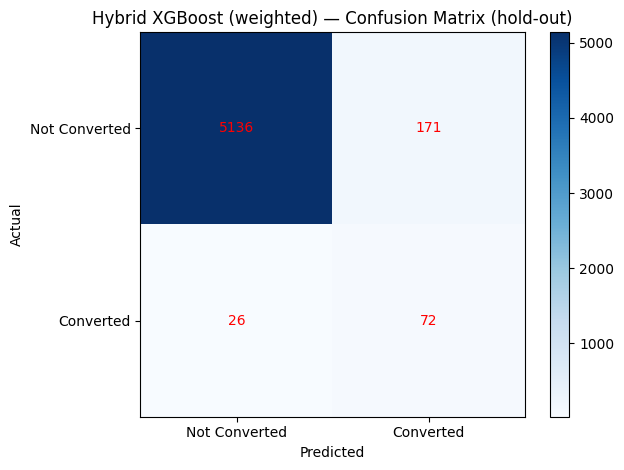

In [59]:
# --- SAFE Step 14: final hold-out evaluation (won't affect your export model) ---

from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 1) Pick the *chosen* model name and pipeline object you used earlier for export
MODEL_NAME = "Hybrid XGBoost (weighted)"   # keep as-is if that's your pick
model_map = {
    "Hybrid Logistic": globals().get("hybrid_pipe"),
    "Hybrid XGBoost (weighted)": globals().get("xgb_hybrid_pipe"),
    "Hybrid LightGBM (weighted)": globals().get("lgbm_hybrid_pipe"),
}
assert model_map[MODEL_NAME] is not None, "Chosen pipeline not found."

# 2) Rebuild the feature matrix for the hybrid model
use_cols = demo_features + [BEHAVIORAL_SCORE_COL]
X_all = abt[use_cols].copy()
X_all[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_all[BEHAVIORAL_SCORE_COL], errors="coerce")

# 3) Recreate the SAME hold-out split (unchanged)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# 4) Clone the pipeline so we don't touch the fitted export model
eval_pipe = clone(model_map[MODEL_NAME])

# 5) Fit ONLY on train, evaluate on test
eval_pipe.fit(X_train, y_train)
proba_test = eval_pipe.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print(f"=== Final hold-out snapshot for {MODEL_NAME} (threshold=0.5) ===")
print(classification_report(y_test, pred_test, zero_division=0))
print("AUC:", round(roc_auc_score(y_test, proba_test), 3))

# 6) Confusion matrix plot (clean)
cm = confusion_matrix(y_test, pred_test)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title(f"{MODEL_NAME} — Confusion Matrix (hold-out)")
plt.colorbar()
plt.xticks([0,1], ["Not Converted","Converted"])
plt.yticks([0,1], ["Not Converted","Converted"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()


# 15) Save ABT for Reuse



In [63]:
import pandas as pd
import numpy as np
import json

abt_fixed = abt.copy()

def _to_str_safe(x):
    if pd.isna(x):
        return np.nan
    # bytes → utf-8 text
    if isinstance(x, (bytes, bytearray)):
        try:
            return x.decode("utf-8", errors="ignore")
        except Exception:
            return str(x)
    # lists / dicts / sets → JSON string
    if isinstance(x, (list, dict, set, tuple)):
        try:
            return json.dumps(x, default=str, ensure_ascii=False)
        except Exception:
            return str(x)
    # numbers → string (but keep integers tidy)
    if isinstance(x, (int, np.integer)):
        return str(int(x))
    if isinstance(x, (float, np.floating)):
        return str(int(x)) if np.isfinite(x) and float(x).is_integer() else str(x)
    # timestamps → ISO string (optional)
    if isinstance(x, (pd.Timestamp, )):
        return x.isoformat()
    return str(x)

# Identify object columns and normalize them to clean strings
obj_cols = abt_fixed.select_dtypes(include=["object"]).columns.tolist()
print("Object columns to sanitize:", obj_cols[:10], "..." if len(obj_cols)>10 else "")

for col in obj_cols:
    # Only coerce if mixed types detected (optional but safer)
    # mixed = abt_fixed[col].dropna().map(type).nunique() > 1
    # if mixed:
    abt_fixed[col] = abt_fixed[col].map(_to_str_safe)

# (Optional) ensure datetime cols are proper dtype (if you have any)
# dt_cols = ["some_date_col"]
# for c in dt_cols:
#     if c in abt_fixed.columns:
#         abt_fixed[c] = pd.to_datetime(abt_fixed[c], errors="coerce")

# Try Parquet again
ABT_PATH = "capstone2_abt.parquet"
abt_fixed.to_parquet(ABT_PATH, index=False)  # uses pyarrow by default
print("Saved ABT to:", ABT_PATH)

# Also save CSV for easy sharing
abt_fixed.to_csv("capstone2_abt.csv", index=False)
print("Saved CSV backup: capstone2_abt.csv")


Object columns to sanitize: ['Form Name', 'Registered Name', 'Application No', 'Registered Email', 'Registered Mobile', 'Form Status', 'Payment Status', 'Payment Method', 'Work Experience', 'LinkedIn'] ...
Saved ABT to: capstone2_abt.parquet
Saved CSV backup: capstone2_abt.csv


# 16A) Install & imports (only once)

In [65]:
# If needed:
!pip install shap --quiet

import numpy as np
import matplotlib.pyplot as plt
import shap



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 16B) Prep encoded matrices + feature names (uses your fitted pipeline)

In [67]:
# Use the fitted hybrid XGB pipeline
xgb_pipe = xgb_hybrid_pipe

# Get fitted preprocessor and classifier
prep = xgb_pipe.named_steps["prep"]
clf  = xgb_pipe.named_steps["clf"]

# Encode train/test the same way the pipeline does
Xtr_enc = prep.transform(Xh_train)
Xte_enc = prep.transform(Xh_test)

# Dense arrays for SHAP
Xtr_dense = Xtr_enc.toarray() if hasattr(Xtr_enc, "toarray") else Xtr_enc
Xte_dense = Xte_enc.toarray() if hasattr(Xte_enc, "toarray") else Xte_enc

# Feature names helper (you already have a variant; this is self-contained)
def get_feature_names_for(preprocessor):
    num_cols = preprocessor.transformers_[0][2]
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_in = preprocessor.transformers_[1][2]
    cat_names = list(ohe.get_feature_names_out(cat_in))
    return list(num_cols) + cat_names

feat_names = get_feature_names_for(prep)


# 16C) Global SHAP summary (what features matter overall)

In [68]:
# Tree explainer for XGBoost
explainer = shap.TreeExplainer(clf)

# SHAP values on a background sample (use full train if it's not too big)
shap_vals = explainer.shap_values(Xtr_dense, check_additivity=False)

# 1) Bar: mean(|SHAP|) per feature (top drivers, easy to read)
shap.summary_plot(shap_vals, Xtr_dense, feature_names=feat_names, plot_type="bar")

# 2) Beeswarm: distribution of effects (color = feature value)
shap.summary_plot(shap_vals, Xtr_dense, feature_names=feat_names)


XGBoostError: bad allocation

# Fix: compute SHAP on a manageable sample (and use approximate mode)

# 1) Build small background + evaluation samples

Use ~500–2,000 rows; start with 800/800 and increase if your RAM allows.

In [69]:
import numpy as np, shap

# Use your fitted Hybrid XGB pipeline pieces
xgb_pipe = xgb_hybrid_pipe
prep = xgb_pipe.named_steps["prep"]
clf  = xgb_pipe.named_steps["clf"]  # XGBClassifier

# Transform once
Xtr_enc = prep.transform(Xh_train)
Xte_enc = prep.transform(Xh_test)

# Convert to dense ONLY for small samples (saves RAM)
def to_dense_small(X, n):
    if hasattr(X, "toarray"):
        # pick a random subset first to avoid densifying the whole matrix
        idx = np.random.RandomState(42).choice(X.shape[0], size=min(n, X.shape[0]), replace=False)
        X_sub = X[idx]
        return X_sub.toarray(), idx
    else:
        idx = np.random.RandomState(42).choice(X.shape[0], size=min(n, X.shape[0]), replace=False)
        return X[idx], idx

BG_N   = 800   # background size for SHAP explainer
TEST_N = 800   # points to visualize

Xbg_dense, bg_idx   = to_dense_small(Xtr_enc, BG_N)
Xvis_dense, vis_idx = to_dense_small(Xte_enc, TEST_N)

# Feature names (same helper you used earlier)
def get_feature_names_for(preprocessor):
    num_cols = preprocessor.transformers_[0][2]
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_in = preprocessor.transformers_[1][2]
    cat_names = list(ohe.get_feature_names_out(cat_in))
    return list(num_cols) + cat_names

feat_names = get_feature_names_for(prep)


# 2) XGBoost booster + approximate SHAP

Approximate contributions drastically reduce memory.

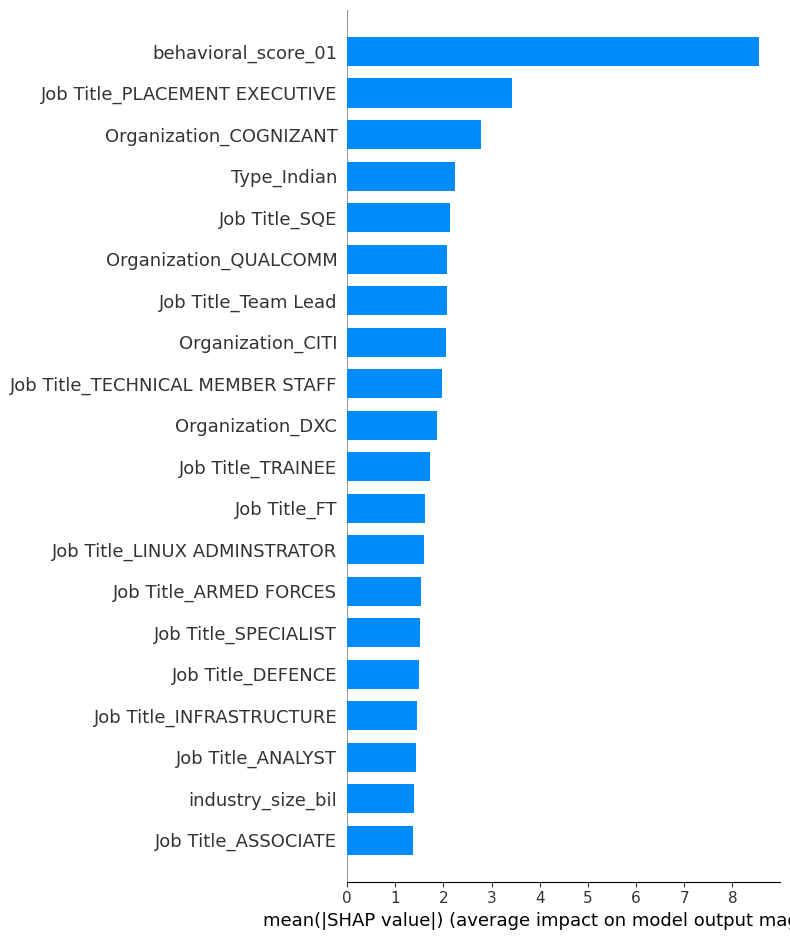

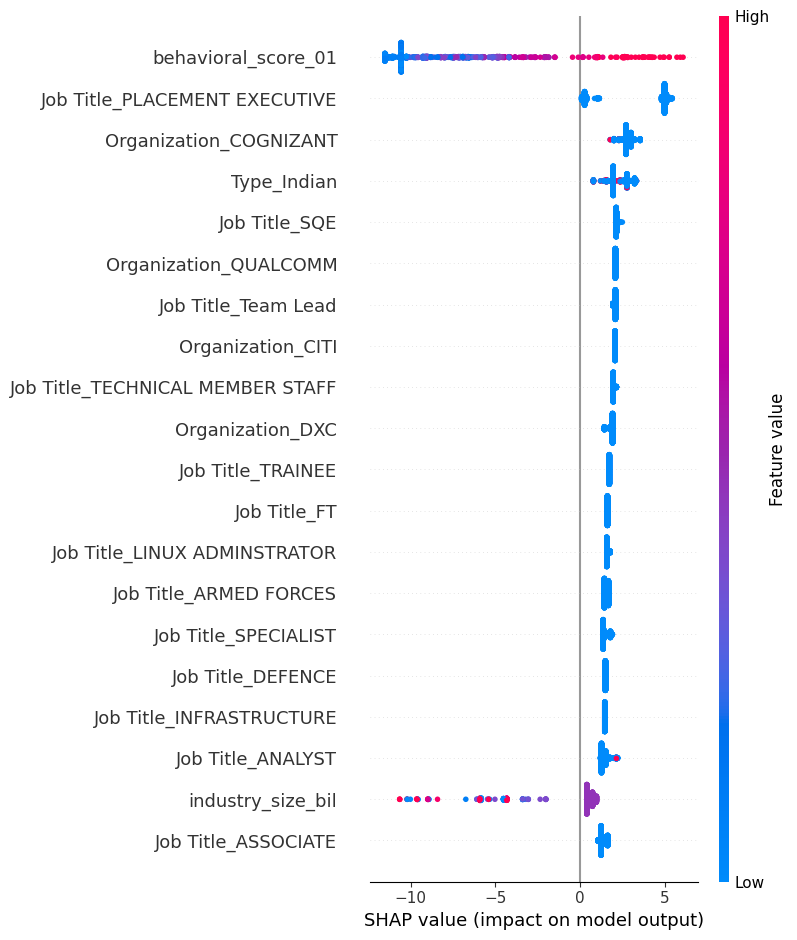

In [74]:
# Assumes you already built:
# - xgb_hybrid_pipe (fitted on Xh_train, yh_train)
# - prep = xgb_hybrid_pipe.named_steps["prep"]
# - clf  = xgb_hybrid_pipe.named_steps["clf"]
# - Xtr_enc = prep.transform(Xh_train)
# - Xte_enc = prep.transform(Xh_test)

import numpy as np, shap

# 1) Sample small background & visualization sets (keeps RAM low)
def to_dense_small(X, n, seed=42):
    rng = np.random.RandomState(seed)
    n_take = min(n, X.shape[0])
    idx = rng.choice(X.shape[0], size=n_take, replace=False)
    X_sub = X[idx]
    X_dense = X_sub.toarray() if hasattr(X_sub, "toarray") else X_sub
    return X_dense, idx

BG_N, TEST_N = 800, 800   # reduce to 400 if RAM is tight
Xbg_dense, _   = to_dense_small(Xtr_enc, BG_N)
Xvis_dense, _  = to_dense_small(Xte_enc, TEST_N)

# 2) Feature names
def get_feature_names_for(preprocessor):
    num_cols = preprocessor.transformers_[0][2]
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_in = preprocessor.transformers_[1][2]
    cat_names = list(ohe.get_feature_names_out(cat_in))
    return list(num_cols) + cat_names

feat_names = get_feature_names_for(prep)

# 3) SHAP explainer: tree_path_dependent requires model_output="raw"
booster = clf.get_booster()
explainer = shap.TreeExplainer(
    booster,
    feature_perturbation="tree_path_dependent",
    model_output="raw"   # <-- REQUIRED with tree_path_dependent
)

# 4) Compute SHAP values on the small visualization set
#    Use approximate & disable additivity check to save memory
shap_vals = explainer.shap_values(
    Xvis_dense,
    check_additivity=False,
    approximate=True
)

# 5) Plots
# Bar: mean(|SHAP|) per feature (top drivers)
shap.summary_plot(shap_vals, Xvis_dense, feature_names=feat_names, plot_type="bar")

# Beeswarm: distribution of effects across samples/features
shap.summary_plot(shap_vals, Xvis_dense, feature_names=feat_names)


In [76]:
from sklearn.inspection import permutation_importance
import pandas as pd, matplotlib.pyplot as plt

feat_names = get_feature_names_for(prep)

result = permutation_importance(
    xgb_hybrid_pipe, Xh_test, yh_test,
    scoring="f1", n_repeats=5, random_state=42, n_jobs=-1
)


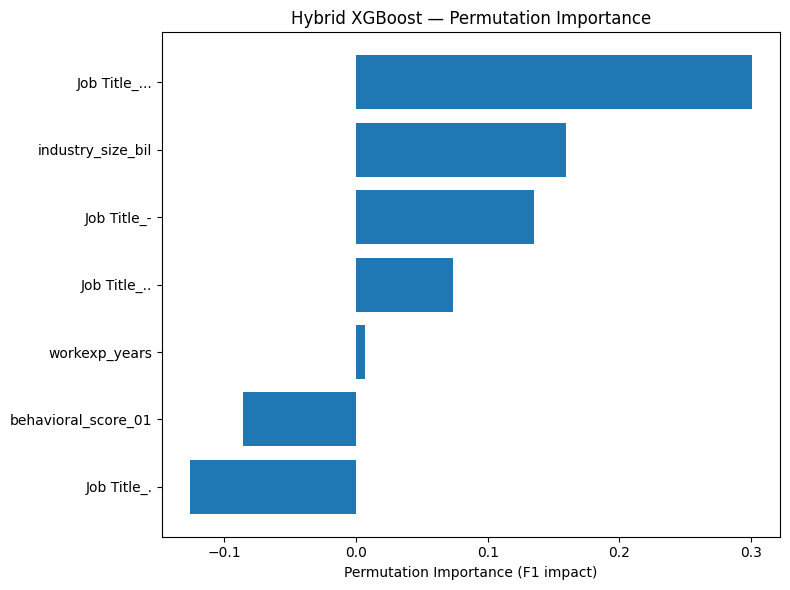

In [77]:
import numpy as np

# Ensure both arrays have the same length
n_feats = len(result.importances_mean)
imp_df = pd.DataFrame({
    "feature": feat_names[:n_feats],
    "importance": result.importances_mean
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(range(len(imp_df)), imp_df["importance"])
plt.yticks(range(len(imp_df)), imp_df["feature"])
plt.xlabel("Permutation Importance (F1 impact)")
plt.title("Hybrid XGBoost — Permutation Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


== Top families by permutation importance (sum of positive impacts) ==


,family,pi_pos
2,Job Title,0.5099
1,Industry Size,0.1593
3,Work Experience,0.0067
0,Behavioral Score,0.0000


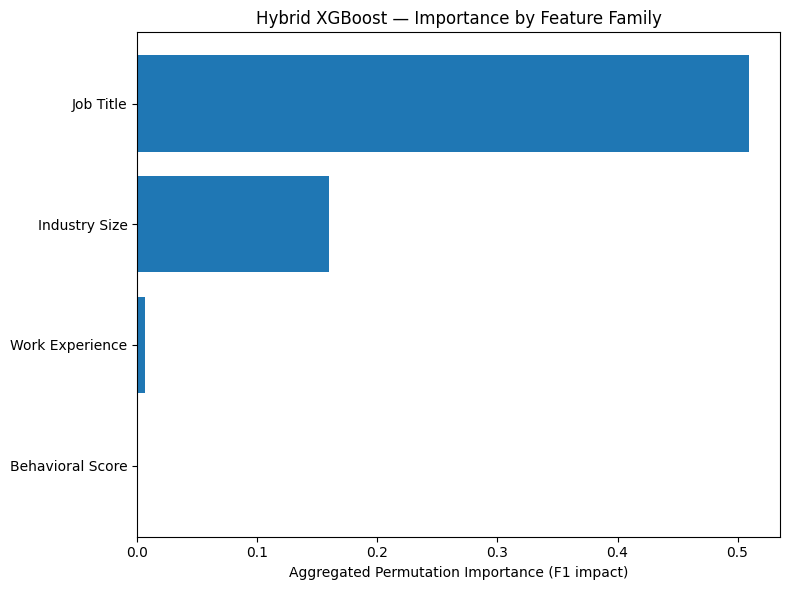


Top features inside family: Job Title


,feature,pi
6,Job Title_...,0.3006
3,Job Title_-,0.1355
5,Job Title_..,0.0738
4,Job Title_.,-0.1257



Top features inside family: Industry Size


,feature,pi
1,industry_size_bil,0.1593



Top features inside family: Work Experience


,feature,pi
0,workexp_years,0.0067


In [78]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pull the raw importances
pi = np.array(result.importances_mean)
n_feats = min(len(pi), len(feat_names))
feat = np.array(feat_names[:n_feats])
pi  = pi[:n_feats]

# 2) A helper that maps each encoded column to a "family"
def family_of(col: str) -> str:
    # numeric fields you used
    if col == "behavioral_score_01": return "Behavioral Score"
    if col == "workexp_years":       return "Work Experience"
    if col == "industry_size_bil":   return "Industry Size"

    # one-hot families (adjust labels to what you actually see in get_feature_names_out)
    if col.startswith("Job Title_"):      return "Job Title"
    if col.startswith("Organization_"):   return "Organization"
    if col.startswith("Industry_"):       return "Industry (Category)"
    if col.startswith("Type_"):           return "Lead Type / Source"

    # fallback — try to infer prefix before first underscore
    m = re.match(r"^([A-Za-z ]+)_", col)
    if m:
        return m.group(1)
    return "Other"

# 3) Build a dataframe and aggregate by family
raw_df = pd.DataFrame({"feature": feat, "pi": pi, "family": [family_of(c) for c in feat]})

# negative permutation importances can occur due to noise; clip to 0 for aggregation clarity
raw_df["pi_pos"] = raw_df["pi"].clip(lower=0.0)

family_df = (raw_df
             .groupby("family", as_index=False)["pi_pos"]
             .sum()
             .sort_values("pi_pos", ascending=False))

print("== Top families by permutation importance (sum of positive impacts) ==")
display(family_df.head(10).round(4))

# 4) Plot families
plt.figure(figsize=(8,6))
plt.barh(family_df["family"].iloc[::-1], family_df["pi_pos"].iloc[::-1])
plt.xlabel("Aggregated Permutation Importance (F1 impact)")
plt.title("Hybrid XGBoost — Importance by Feature Family")
plt.tight_layout()
plt.show()

# 5) (Optional) show top members inside each of the top families
TOP_FAMS = family_df.head(3)["family"].tolist()  # change 3→5 if you want more
for fam in TOP_FAMS:
    top_members = (raw_df[raw_df["family"]==fam]
                   .sort_values("pi", ascending=False)
                   .head(10))
    print(f"\nTop features inside family: {fam}")
    display(top_members[["feature","pi"]].round(4))


# 16D) SHAP — Dependence Plots (multiple)

Top features for dependence plots: ['behavioral_score_01', 'Job Title_PLACEMENT EXECUTIVE', 'Organization_COGNIZANT', 'Type_Indian', 'Job Title_SQE', 'Organization_QUALCOMM']


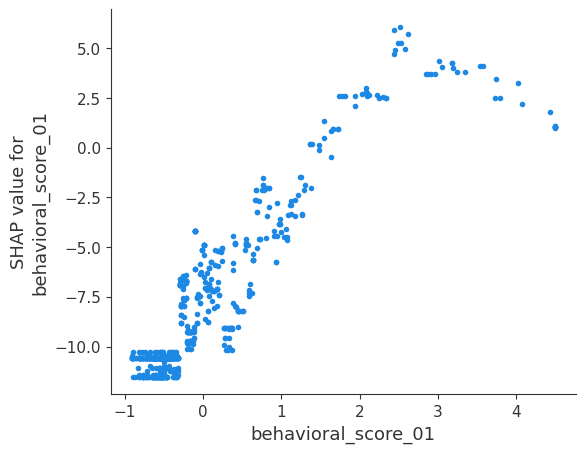

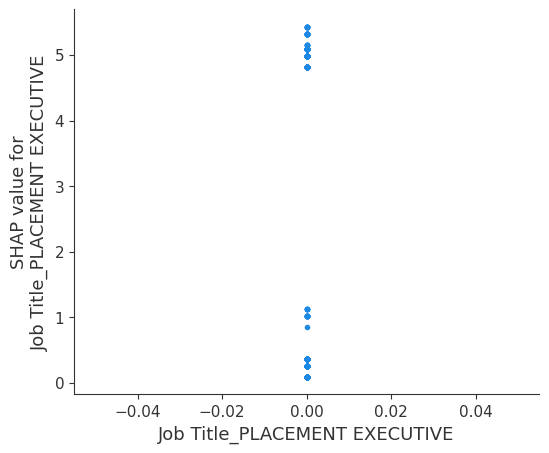

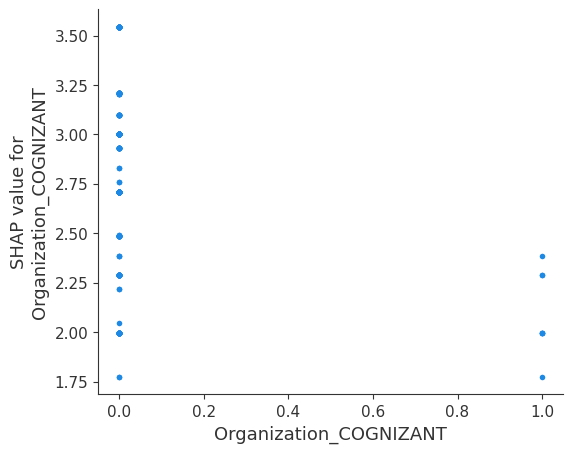

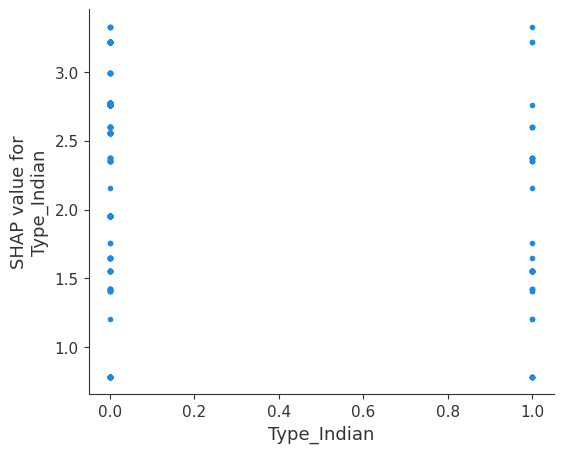

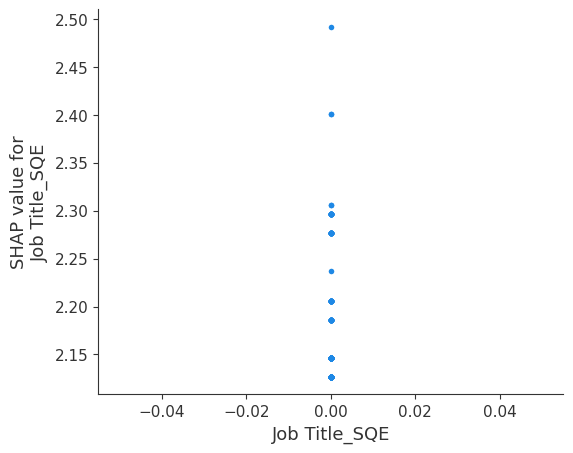

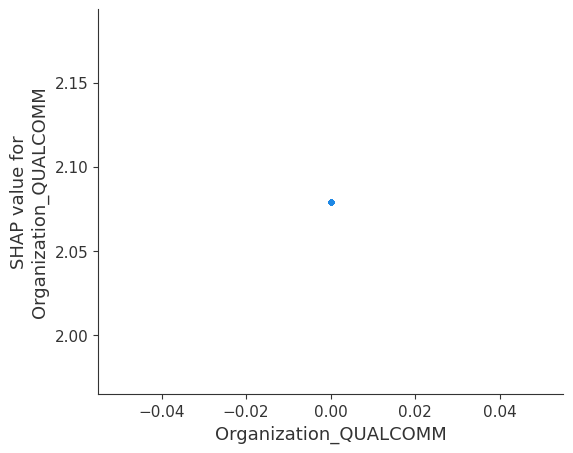

In [79]:
# === 16D) SHAP Dependence Plots (Hybrid XGBoost) ===
import numpy as np, shap
import matplotlib.pyplot as plt

# Pipeline parts
prep = xgb_hybrid_pipe.named_steps["prep"]
clf  = xgb_hybrid_pipe.named_steps["clf"]

# Transform train/test like the pipeline
Xtr_enc = prep.transform(Xh_train)
Xte_enc = prep.transform(Xh_test)

# Sample manageable background & visualization sets (keeps RAM low)
def to_dense_small(X, n, seed=42):
    rng = np.random.RandomState(seed)
    n_take = min(n, X.shape[0])
    idx = rng.choice(X.shape[0], size=n_take, replace=False)
    X_sub = X[idx]
    X_dense = X_sub.toarray() if hasattr(X_sub, "toarray") else X_sub
    return X_dense, idx

BG_N, TEST_N = 800, 800     # lower to 400 if memory is tight
Xbg_dense, _    = to_dense_small(Xtr_enc, BG_N)
Xvis_dense, _   = to_dense_small(Xte_enc, TEST_N)

# Feature names for encoded matrix
def get_feature_names_for(preprocessor):
    num_cols = preprocessor.transformers_[0][2]
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_in = preprocessor.transformers_[1][2]
    cat_names = list(ohe.get_feature_names_out(cat_in))
    return list(num_cols) + cat_names

feat_names = get_feature_names_for(prep)

# SHAP explainer (XGBoost) — tree_path_dependent requires model_output="raw"
booster = clf.get_booster()
explainer = shap.TreeExplainer(
    booster,
    feature_perturbation="tree_path_dependent",
    model_output="raw"
)

# SHAP on visualization subset (fast) 
shap_vals = explainer.shap_values(
    Xvis_dense, check_additivity=False, approximate=True
)

# Pick top K features by mean |SHAP|
K = 6
order = np.argsort(np.abs(shap_vals).mean(axis=0))[::-1][:K]
top_feats = [feat_names[i] for i in order]
print("Top features for dependence plots:", top_feats)

# Dependence plots (one figure per feature)
for f in top_feats:
    shap.dependence_plot(
        f, shap_vals, Xvis_dense,
        feature_names=feat_names,
        interaction_index=None
    )


# 16E) SHAP — Local Explanations (top positives & hard negatives)

This makes waterfall plots for the top-3 highest probability leads and top-3 lowest (missed) in the test set.

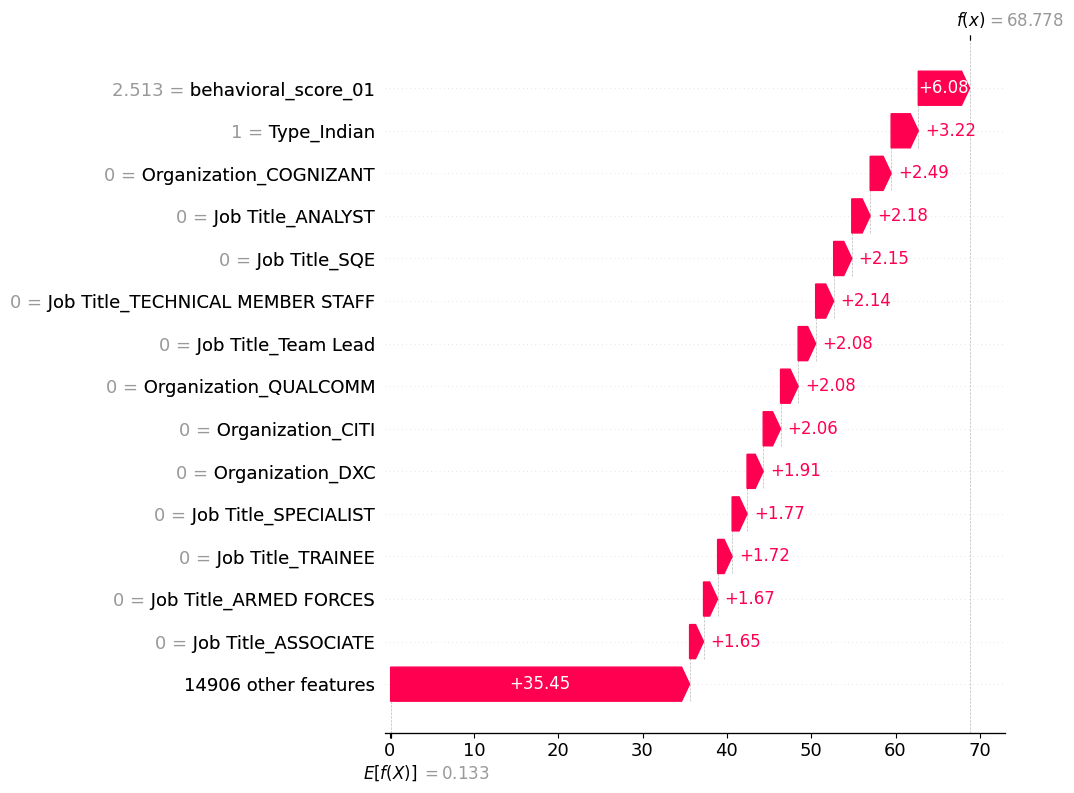

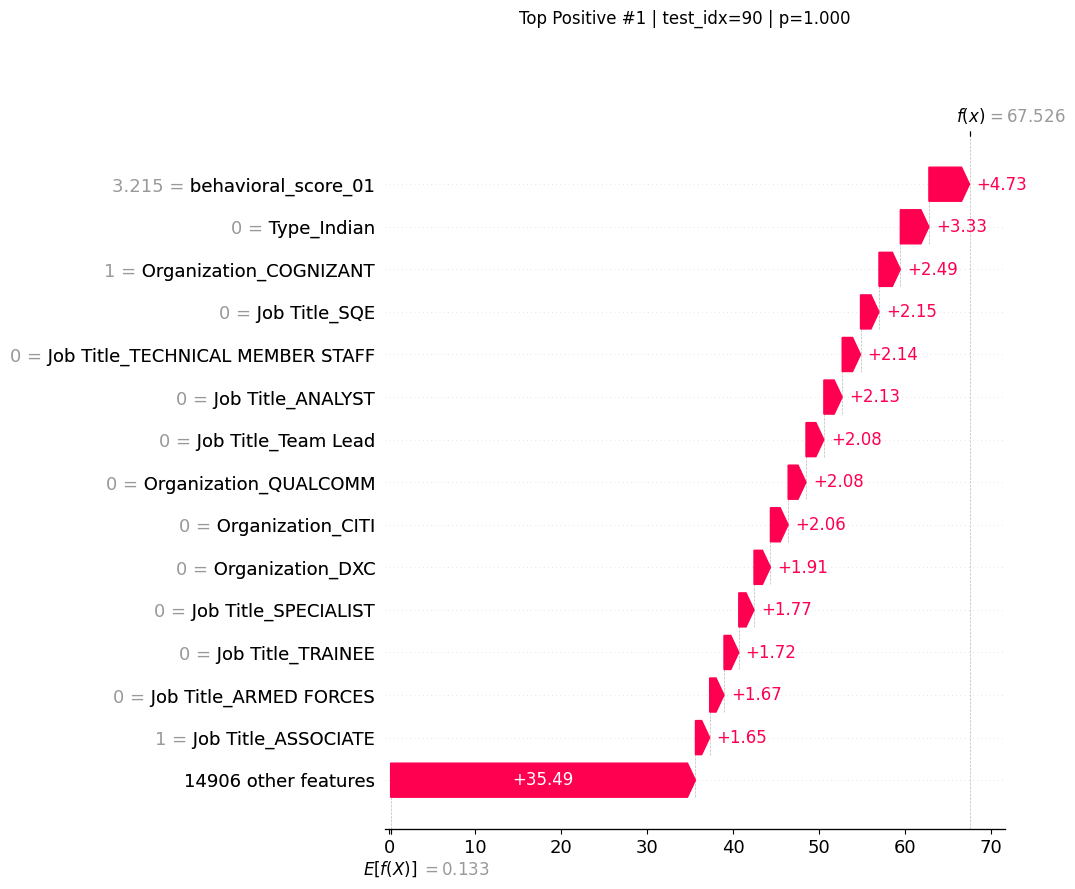

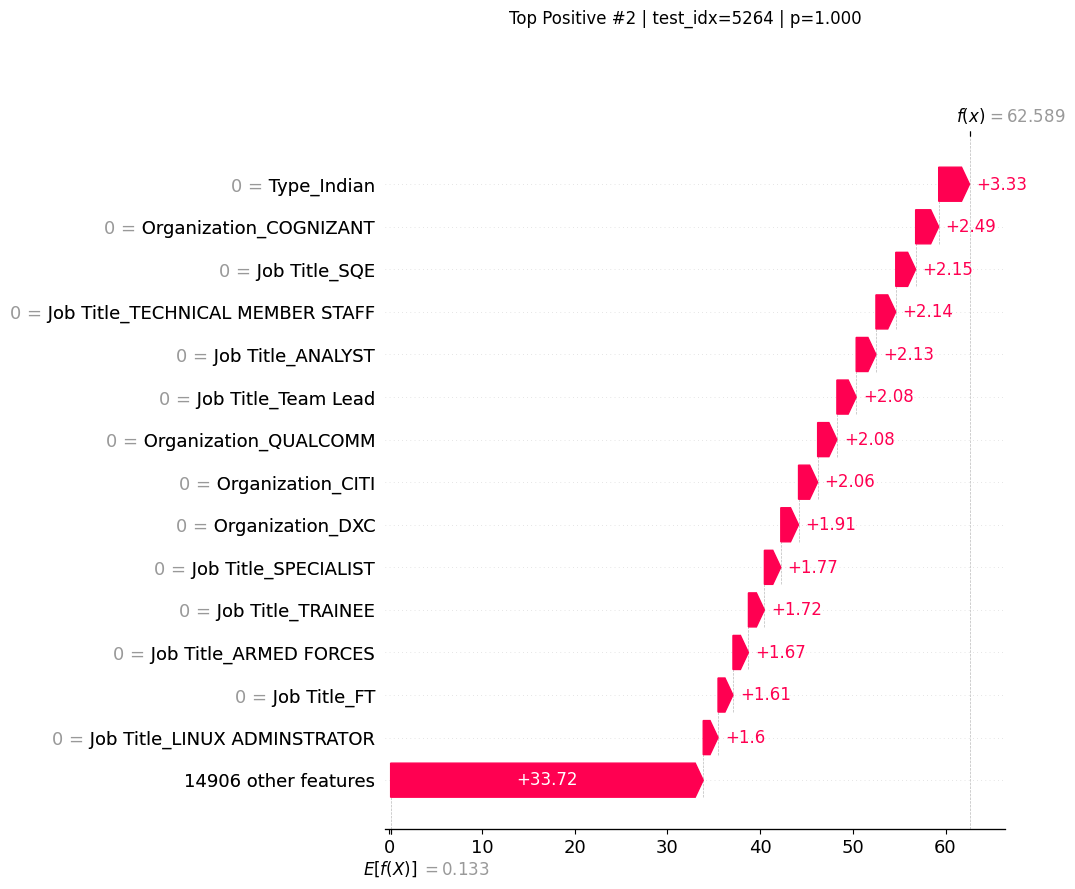

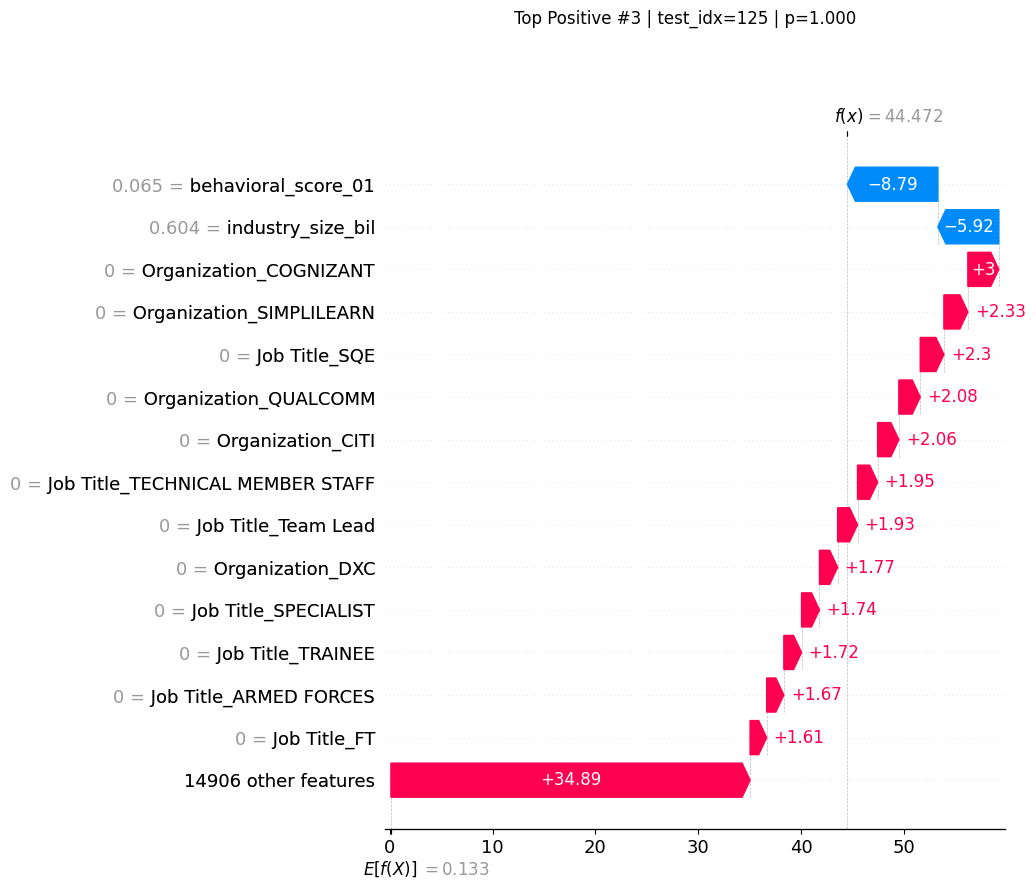

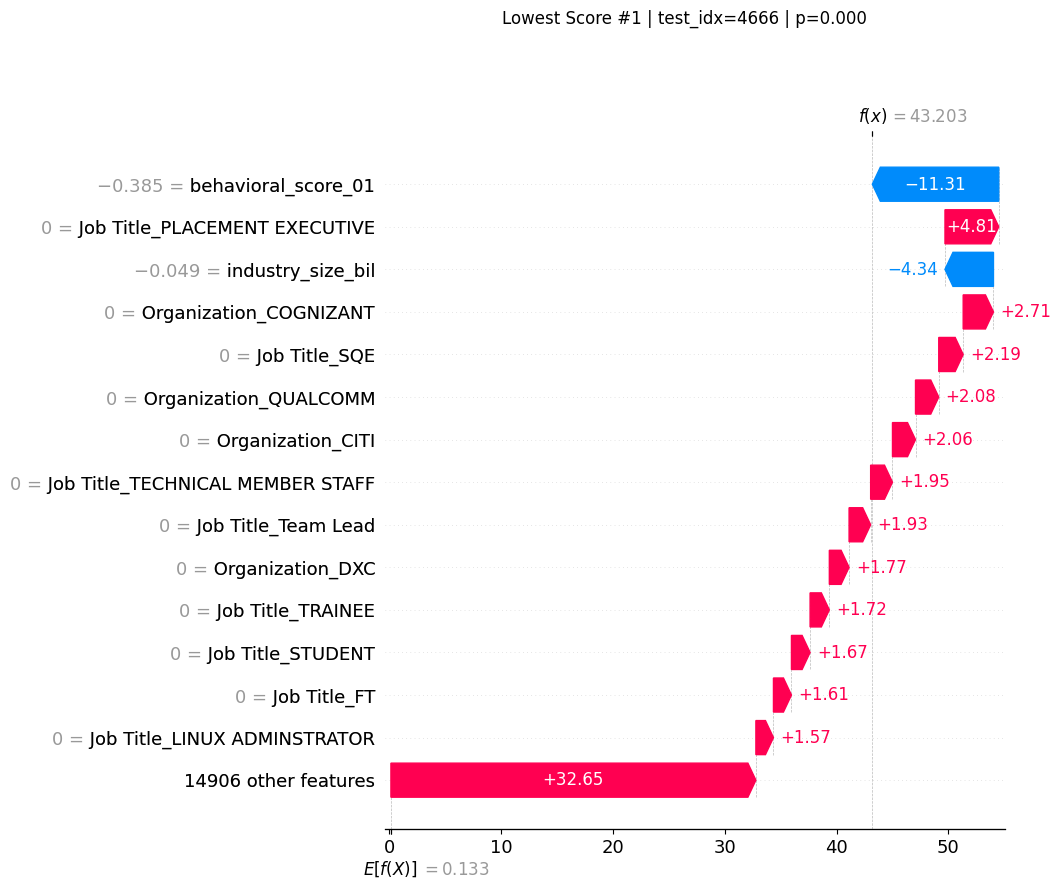

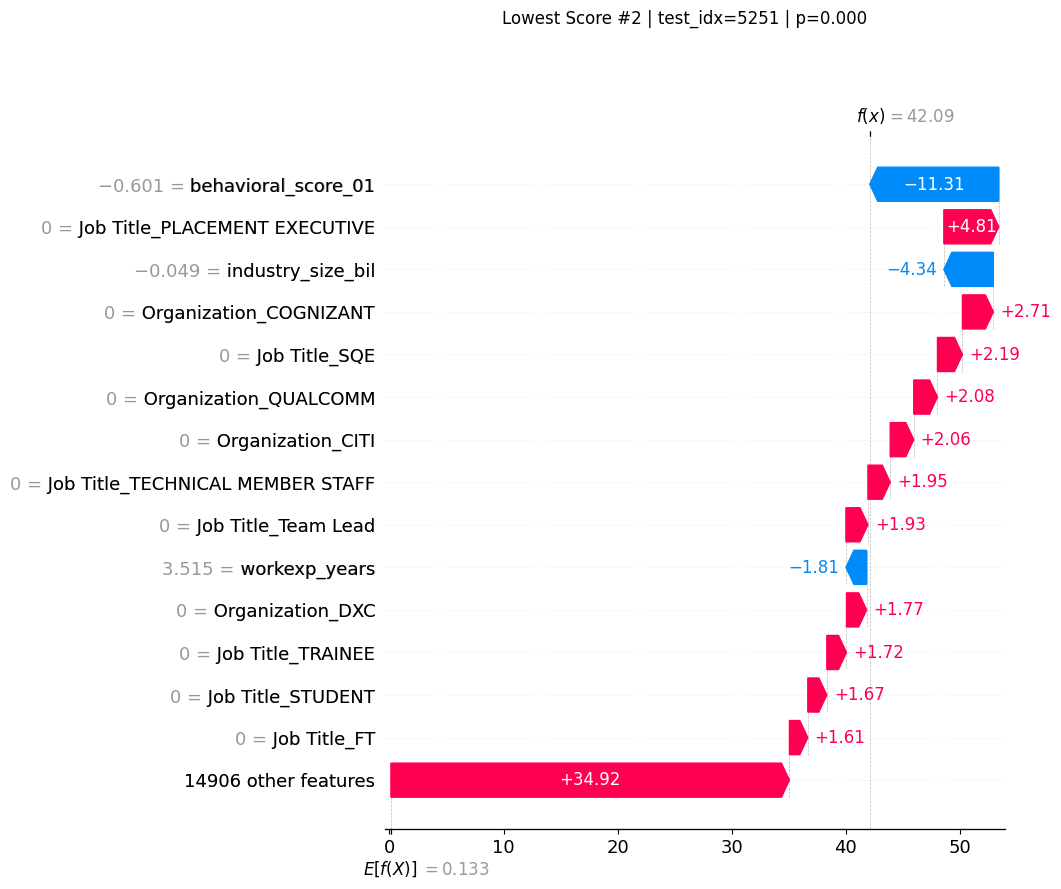

<Figure size 640x480 with 0 Axes>

In [80]:
# === 16E) SHAP Local Explanations (Hybrid XGBoost) ===
import numpy as np, shap

# Predict probabilities on the test fold using the pipeline (not the small sample)
proba_test = xgb_hybrid_pipe.predict_proba(Xh_test)[:, 1]

# Indices for top positive predictions and lowest predictions
topN = 3
top_pos_idx = np.argsort(proba_test)[-topN:][::-1]    # highest probs
top_neg_idx = np.argsort(proba_test)[:topN]           # lowest probs

# We need SHAP values for those specific rows: transform & densify just those
Xte_enc_full = prep.transform(Xh_test)
def to_dense_rows(X, idx):
    X_sel = X[idx]
    return X_sel.toarray() if hasattr(X_sel, "toarray") else X_sel

X_pos = to_dense_rows(Xte_enc_full, top_pos_idx)
X_neg = to_dense_rows(Xte_enc_full, top_neg_idx)

# Reuse the same explainer
# Compute SHAP values for the selected rows
shap_pos = explainer.shap_values(X_pos, check_additivity=False, approximate=True)
shap_neg = explainer.shap_values(X_neg, check_additivity=False, approximate=True)

# Plot waterfalls for each chosen row
shap.initjs()

def waterfall_for_row(values, base, data_row, title):
    # Newer SHAP API prefers Explanation objects
    exp = shap.Explanation(
        values=values,
        base_values=base,
        data=data_row,
        feature_names=feat_names
    )
    shap.plots.waterfall(exp, max_display=15, show=True)
    plt.suptitle(title, y=1.02)

# Expected value (base)
base_val = explainer.expected_value

# Top positives
for i, idx in enumerate(top_pos_idx):
    waterfall_for_row(
        shap_pos[i, :],
        base_val,
        X_pos[i, :],
        title=f"Top Positive #{i+1} | test_idx={idx} | p={proba_test[idx]:.3f}"
    )

# Hard negatives (very low score)
for i, idx in enumerate(top_neg_idx):
    waterfall_for_row(
        shap_neg[i, :],
        base_val,
        X_neg[i, :],
        title=f"Lowest Score #{i+1} | test_idx={idx} | p={proba_test[idx]:.3f}"
    )


# 17) Probability Calibration (reliability & calibrated models)

This compares uncalibrated hybrid-XGB against sigmoid (Platt) and isotonic calibration, shows reliability curves and Brier scores (lower is better), and prints AUC for reference.

Uncalibrated  | Brier=0.0225  AUC=0.9710
Sigmoid Calib | Brier=0.0098  AUC=0.9717
Isotonic Calib| Brier=0.0072  AUC=0.9739


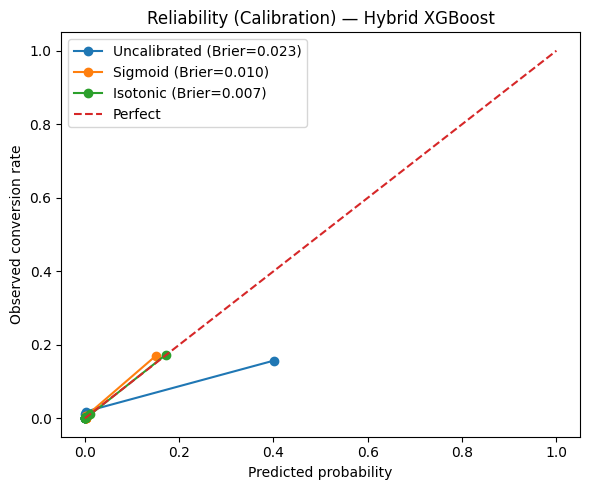

In [82]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Uncalibrated (already computed in your cell, keeping it here for completeness)
proba_unc = xgb_hybrid_pipe.predict_proba(Xh_test)[:, 1]
brier_unc = brier_score_loss(yh_test, proba_unc)
auc_unc   = roc_auc_score(yh_test, proba_unc)
print(f"Uncalibrated  | Brier={brier_unc:.4f}  AUC={auc_unc:.4f}")

# ---- FIX: use `estimator=` (fallback to `base_estimator=` for older sklearn) ----
def make_calibrator(est, method):
    try:
        return CalibratedClassifierCV(estimator=est, method=method, cv=5)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=est, method=method, cv=5)

cal_sig = make_calibrator(xgb_hybrid_pipe, method="sigmoid")
cal_iso = make_calibrator(xgb_hybrid_pipe, method="isotonic")

# Fit calibrators on TRAIN data (they do internal CV on the train split)
cal_sig.fit(Xh_train, yh_train)
cal_iso.fit(Xh_train, yh_train)

# Probabilities on TEST
proba_sig = cal_sig.predict_proba(Xh_test)[:, 1]
proba_iso = cal_iso.predict_proba(Xh_test)[:, 1]

brier_sig = brier_score_loss(yh_test, proba_sig)
brier_iso = brier_score_loss(yh_test, proba_iso)
auc_sig   = roc_auc_score(yh_test, proba_sig)
auc_iso   = roc_auc_score(yh_test, proba_iso)

print(f"Sigmoid Calib | Brier={brier_sig:.4f}  AUC={auc_sig:.4f}")
print(f"Isotonic Calib| Brier={brier_iso:.4f}  AUC={auc_iso:.4f}")

# Reliability curves (quantile bins keep samples per bin balanced)
prob_true_u, prob_pred_u = calibration_curve(yh_test, proba_unc, n_bins=10, strategy="quantile")
prob_true_s, prob_pred_s = calibration_curve(yh_test, proba_sig, n_bins=10, strategy="quantile")
prob_true_i, prob_pred_i = calibration_curve(yh_test, proba_iso, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,5))
plt.plot(prob_pred_u, prob_true_u, "o-", label=f"Uncalibrated (Brier={brier_unc:.3f})")
plt.plot(prob_pred_s, prob_true_s, "o-", label=f"Sigmoid (Brier={brier_sig:.3f})")
plt.plot(prob_pred_i, prob_true_i, "o-", label=f"Isotonic (Brier={brier_iso:.3f})")
plt.plot([0,1],[0,1], "--", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed conversion rate")
plt.title("Reliability (Calibration) — Hybrid XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


# 19) Cross-validation stability (Hybrid XGBoost pipeline)

In [83]:
# === 19) Cross-validation stability (Hybrid XGBoost pipeline) ===
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import numpy as np
import pandas as pd

# Use your hybrid feature matrix & labels
Xcv, ycv = X_hybrid, y  # (same columns used to fit xgb_hybrid_pipe)

# 5-fold stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get out-of-fold probabilities from the full pipeline
# (predict_proba per fold -> concatenated in original order)
proba_oof = cross_val_predict(
    xgb_hybrid_pipe, Xcv, ycv,
    cv=skf, method="predict_proba", n_jobs=-1
)[:, 1]

# Compute per-fold AUC as well (for mean ± std)
fold_aucs = []
for tr_idx, te_idx in skf.split(Xcv, ycv):
    X_tr, X_te = Xcv.iloc[tr_idx], Xcv.iloc[te_idx]
    y_tr, y_te = ycv.iloc[tr_idx], ycv.iloc[te_idx]
    pipe = xgb_hybrid_pipe
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_te)[:, 1]
    fold_aucs.append(roc_auc_score(y_te, p))

cv_auc_mean  = np.mean(fold_aucs)
cv_auc_std   = np.std(fold_aucs)
cv_pr_auc    = average_precision_score(ycv, proba_oof)  # PR-AUC on OOF
cv_brier     = brier_score_loss(ycv, proba_oof)

print(f"5-fold AUC: {cv_auc_mean:.4f} ± {cv_auc_std:.4f}")
print(f"OOF PR-AUC: {cv_pr_auc:.4f}")
print(f"OOF Brier : {cv_brier:.4f}")

# Optional: table per fold
pd.DataFrame({"fold": range(1,6), "AUC": np.round(fold_aucs, 4)})


5-fold AUC: 0.9743 ± 0.0053
OOF PR-AUC: 0.7465
OOF Brier : 0.0214


,fold,AUC
0,1,0.9754
1,2,0.9681
2,3,0.9798
3,4,0.9799
4,5,0.9682


# 20) Export scored leads with calibrated probability, rank, and bands (NEW file)

In [84]:
# === 20) Export all leads with CALIBRATED probability, rank & bands ===
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import pandas as pd

# 1) Build a calibrated version of your chosen best model (isotonic works best from your results)
def make_calibrator(est, method="isotonic"):
    try:
        return CalibratedClassifierCV(estimator=est, method=method, cv=5)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=est, method=method, cv=5)

cal_best = make_calibrator(xgb_hybrid_pipe, method="isotonic")
cal_best.fit(Xh_train, yh_train)   # fit on the train split

# 2) Score ALL rows in your ABT using the **hybrid** feature matrix
X_all_hybrid = abt[demo_features + [BEHAVIORAL_SCORE_COL]].copy()
X_all_hybrid[BEHAVIORAL_SCORE_COL] = pd.to_numeric(
    X_all_hybrid[BEHAVIORAL_SCORE_COL], errors="coerce"
)

prob_cal = cal_best.predict_proba(X_all_hybrid)[:, 1]

# 3) Rank and bands
# If you already have hard thresholds T_VH/T_H/T_M, set them here; otherwise fallback to quantiles
USE_FIXED_THRESHOLDS = False  # <- set True if you want to reuse your earlier numeric cutoffs
if USE_FIXED_THRESHOLDS:
    T_VH = 0.70   # example – replace with your chosen values
    T_H  = 0.40
    T_M  = 0.15

def make_band_series(prob, use_fixed=False):
    s = pd.Series(prob, index=abt.index)
    if use_fixed:
        return pd.Series(
            np.select(
                [s >= T_VH, s >= T_H, s >= T_M],
                ["Very High", "High", "Medium"],
                default="Low"
            ),
            index=abt.index
        )
    else:
        # Quantile bands: Top 10% = Very High, next 20% = High, next 30% = Medium, rest = Low
        q90, q70, q40 = np.quantile(s, [0.90, 0.70, 0.40])
        return pd.Series(
            np.select(
                [s >= q90, s >= q70, s >= q40],
                ["Very High", "High", "Medium"],
                default="Low"
            ),
            index=abt.index
        )

bands = make_band_series(prob_cal, use_fixed=USE_FIXED_THRESHOLDS)

# Add percentile rank (0=lowest, 100=highest)
rank_pct = pd.Series(pd.qcut(prob_cal, q=100, labels=False, duplicates="drop"), index=abt.index)
rank_pct = (rank_pct / rank_pct.max() * 100).round(1)

# 4) Assemble export table (add any ID columns you want to keep)
cols_to_keep = []
for c in ["Lead ID", "Email", "Phone", "Name"]:   # keep what exists
    if c in abt.columns:
        cols_to_keep.append(c)

export_df = abt[cols_to_keep].copy()
export_df["prob_calibrated"] = prob_cal
export_df["rank_percentile"] = rank_pct
export_df["band"] = bands

# 5) Save to a NEW filename so nothing is overwritten
OUTFILE = "capstone2_scored_calibrated_ranked.xlsx"
export_df.to_excel(OUTFILE, index=False)
print("Saved:", OUTFILE)

# (Optional) quick sanity: band counts
print("\nBand counts:")
print(export_df["band"].value_counts())


Saved: capstone2_scored_calibrated_ranked.xlsx

Band counts:
band
Low          10789
High          6945
Medium        6587
Very High     2703
Name: count, dtype: int64


In [86]:
# === 20A) FULL EXPORT with ALL abt columns + calibrated probability + rank + ONE band set ===
import numpy as np, pandas as pd
from sklearn.calibration import CalibratedClassifierCV

# --- choose quantile bands (stable volumes) OR fixed thresholds (confidence) ---
USE_QUANTILE_BANDS = True  # set False to use fixed thresholds below

# --- (re)build isotonic calibrator on your chosen hybrid model ---
def make_calibrator(est, method="isotonic"):
    try:
        return CalibratedClassifierCV(estimator=est, method=method, cv=5)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=est, method=method, cv=5)

cal_best = make_calibrator(xgb_hybrid_pipe, method="isotonic")
cal_best.fit(Xh_train, yh_train)

# --- feature matrix for ALL rows (hybrid = demo + behavioral) ---
X_all_hybrid = abt[demo_features + [BEHAVIORAL_SCORE_COL]].copy()
X_all_hybrid[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_all_hybrid[BEHAVIORAL_SCORE_COL], errors="coerce")

# --- calibrated probabilities for ALL rows ---
prob_cal = cal_best.predict_proba(X_all_hybrid)[:, 1]

# --- rank percentile (0..100) ---
rank_pct = pd.Series(pd.qcut(prob_cal, q=100, labels=False, duplicates="drop"), index=abt.index)
rank_pct = (rank_pct / rank_pct.max() * 100).round(1)

# --- bands ---
if USE_QUANTILE_BANDS:
    q90, q70, q40 = np.quantile(prob_cal, [0.90, 0.70, 0.40])
    def bander(p):
        if p >= q90: return "Very High"
        if p >= q70: return "High"
        if p >= q40: return "Medium"
        return "Low"
    band_series = pd.Series([bander(p) for p in prob_cal], index=abt.index, name="band")
else:
    # set your own fixed probability cutoffs here:
    T_VH, T_H, T_M = 0.60, 0.30, 0.10
    def bander_fixed(p):
        if p >= T_VH: return "Very High"
        if p >= T_H:  return "High"
        if p >= T_M:  return "Medium"
        return "Low"
    band_series = pd.Series([bander_fixed(p) for p in prob_cal], index=abt.index, name="band")

# --- build export with ALL original columns + new scoring columns first ---
new_cols = pd.DataFrame({
    "prob_calibrated": prob_cal,
    "rank_percentile": rank_pct,
    "band": band_series,
}, index=abt.index)

# Put scoring columns first, then all original abt columns
export_df = pd.concat([new_cols, abt], axis=1)

OUTFILE = "capstone2_scored_CALIB_full.xlsx"
with pd.ExcelWriter(OUTFILE, engine="xlsxwriter") as writer:
    export_df.to_excel(writer, index=False, sheet_name="All_scored_full")
    # optional: per-band sheets for convenience
    for b in ["Very High","High","Medium","Low"]:
        export_df.loc[export_df["band"]==b].to_excel(writer, index=False, sheet_name=f"{b}")

print("Saved:", OUTFILE)
print("Band counts:")
print(export_df["band"].value_counts())


Saved: capstone2_scored_CALIB_full.xlsx
Band counts:
band
Low          10789
High          6945
Medium        6587
Very High     2703
Name: count, dtype: int64


# Dual bands export (quantiles + fixed thresholds)

In [85]:
# === Dual Bands Export: quantile & threshold side-by-side ===
import numpy as np, pandas as pd
from sklearn.calibration import CalibratedClassifierCV

# 1) Calibrated model (isotonic)
def make_calibrator(est, method="isotonic"):
    try:
        return CalibratedClassifierCV(estimator=est, method=method, cv=5)
    except TypeError:  # older sklearn
        return CalibratedClassifierCV(base_estimator=est, method=method, cv=5)

cal_best = make_calibrator(xgb_hybrid_pipe, method="isotonic")
cal_best.fit(Xh_train, yh_train)

# 2) Build full hybrid feature matrix for ALL rows
X_all_hybrid = abt[demo_features + [BEHAVIORAL_SCORE_COL]].copy()
X_all_hybrid[BEHAVIORAL_SCORE_COL] = pd.to_numeric(
    X_all_hybrid[BEHAVIORAL_SCORE_COL], errors="coerce"
)

# Calibrated probabilities for ALL rows
prob_cal = cal_best.predict_proba(X_all_hybrid)[:, 1]

# 3) Rank (0–100 percentile)
rank_pct = pd.Series(pd.qcut(prob_cal, q=100, labels=False, duplicates="drop"), index=abt.index)
rank_pct = (rank_pct / rank_pct.max() * 100).round(1)

# 4A) Quantile-based bands (10/20/30/40%)
q90, q70, q40 = np.quantile(prob_cal, [0.90, 0.70, 0.40])
band_quant = pd.Series(
    np.select(
        [prob_cal >= q90, prob_cal >= q70, prob_cal >= q40],
        ["Very High", "High", "Medium"],
        default="Low"
    ),
    index=abt.index
)

# 4B) Threshold-based bands (set your own cutoffs here)
# Use your previously decided thresholds; example placeholders below:
T_VH = 0.60   # Very High if prob >= 0.60
T_H  = 0.30   # High       if prob >= 0.30
T_M  = 0.10   # Medium     if prob >= 0.10
band_thr = pd.Series(
    np.select(
        [prob_cal >= T_VH, prob_cal >= T_H, prob_cal >= T_M],
        ["Very High", "High", "Medium"],
        default="Low"
    ),
    index=abt.index
)

# 5) Assemble export table (keep whatever ID columns exist)
cols_to_keep = []
for c in ["Lead ID", "Email", "Phone", "Name"]:
    if c in abt.columns:
        cols_to_keep.append(c)

export_df = abt[cols_to_keep].copy()
export_df["prob_calibrated"]   = prob_cal
export_df["rank_percentile"]   = rank_pct
export_df["band_quantile"]     = band_quant
export_df["band_threshold"]    = band_thr
export_df["q90_cutoff"]        = q90   # helpful metadata
export_df["q70_cutoff"]        = q70
export_df["q40_cutoff"]        = q40
export_df["T_VH_used"]         = T_VH  # helpful metadata
export_df["T_H_used"]          = T_H
export_df["T_M_used"]          = T_M

# 6) Save to a NEW file
OUTFILE = "capstone2_scored_dual_bands.xlsx"
export_df.to_excel(OUTFILE, index=False)
print("Saved:", OUTFILE)

# 7) Quick band counts
print("\nQuantile bands:")
print(export_df["band_quantile"].value_counts().rename_axis("band").to_frame("count"))
print("\nThreshold bands:")
print(export_df["band_threshold"].value_counts().rename_axis("band").to_frame("count"))


Saved: capstone2_scored_dual_bands.xlsx

Quantile bands:
           count
band            
Low        10789
High        6945
Medium      6587
Very High   2703

Threshold bands:
           count
band            
Low        26487
Very High    334
High         124
Medium        79


In [87]:
# === 20B) FULL EXPORT with ALL abt columns + calibrated probability + rank + BOTH band styles ===
import numpy as np, pandas as pd
from sklearn.calibration import CalibratedClassifierCV

# --- (re)build isotonic calibrator on your chosen hybrid model ---
def make_calibrator(est, method="isotonic"):
    try:
        return CalibratedClassifierCV(estimator=est, method=method, cv=5)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=est, method=method, cv=5)

cal_best = make_calibrator(xgb_hybrid_pipe, method="isotonic")
cal_best.fit(Xh_train, yh_train)

# --- feature matrix for ALL rows (hybrid = demo + behavioral) ---
X_all_hybrid = abt[demo_features + [BEHAVIORAL_SCORE_COL]].copy()
X_all_hybrid[BEHAVIORAL_SCORE_COL] = pd.to_numeric(X_all_hybrid[BEHAVIORAL_SCORE_COL], errors="coerce")

# --- calibrated probabilities for ALL rows ---
prob_cal = cal_best.predict_proba(X_all_hybrid)[:, 1]

# --- rank percentile (0..100) ---
rank_pct = pd.Series(pd.qcut(prob_cal, q=100, labels=False, duplicates="drop"), index=abt.index)
rank_pct = (rank_pct / rank_pct.max() * 100).round(1)

# --- quantile bands (10/20/30/40) ---
q90, q70, q40 = np.quantile(prob_cal, [0.90, 0.70, 0.40])
def band_quant(p):
    if p >= q90: return "Very High"
    if p >= q70: return "High"
    if p >= q40: return "Medium"
    return "Low"
band_quantile = pd.Series([band_quant(p) for p in prob_cal], index=abt.index, name="band_quantile")

# --- fixed threshold bands (set your cutoffs here) ---
T_VH, T_H, T_M = 0.60, 0.30, 0.10
def band_fixed(p):
    if p >= T_VH: return "Very High"
    if p >= T_H:  return "High"
    if p >= T_M:  return "Medium"
    return "Low"
band_threshold = pd.Series([band_fixed(p) for p in prob_cal], index=abt.index, name="band_threshold")

# --- build export with ALL original columns + new scoring columns first ---
meta_cols = pd.DataFrame({
    "prob_calibrated": prob_cal,
    "rank_percentile": rank_pct,
    "band_quantile": band_quantile,
    "band_threshold": band_threshold,
    "q90_cutoff": q90,
    "q70_cutoff": q70,
    "q40_cutoff": q40,
    "T_VH_used": T_VH,
    "T_H_used": T_H,
    "T_M_used": T_M,
}, index=abt.index)

export_df = pd.concat([meta_cols, abt], axis=1)

OUTFILE = "capstone2_scored_DUAL_BANDS_full.xlsx"
with pd.ExcelWriter(OUTFILE, engine="xlsxwriter") as writer:
    export_df.to_excel(writer, index=False, sheet_name="All_scored_full")
    # optional: convenience sheets for each band style
    for b in ["Very High","High","Medium","Low"]:
        export_df.loc[export_df["band_quantile"]==b].to_excel(writer, index=False, sheet_name=f"Q_{b}")
        export_df.loc[export_df["band_threshold"]==b].to_excel(writer, index=False, sheet_name=f"T_{b}")

print("Saved:", OUTFILE)
print("\nQuantile bands:")
print(export_df["band_quantile"].value_counts())
print("\nThreshold bands:")
print(export_df["band_threshold"].value_counts())


Saved: capstone2_scored_DUAL_BANDS_full.xlsx

Quantile bands:
band_quantile
Low          10789
High          6945
Medium        6587
Very High     2703
Name: count, dtype: int64

Threshold bands:
band_threshold
Low          26487
Very High      334
High           124
Medium          79
Name: count, dtype: int64


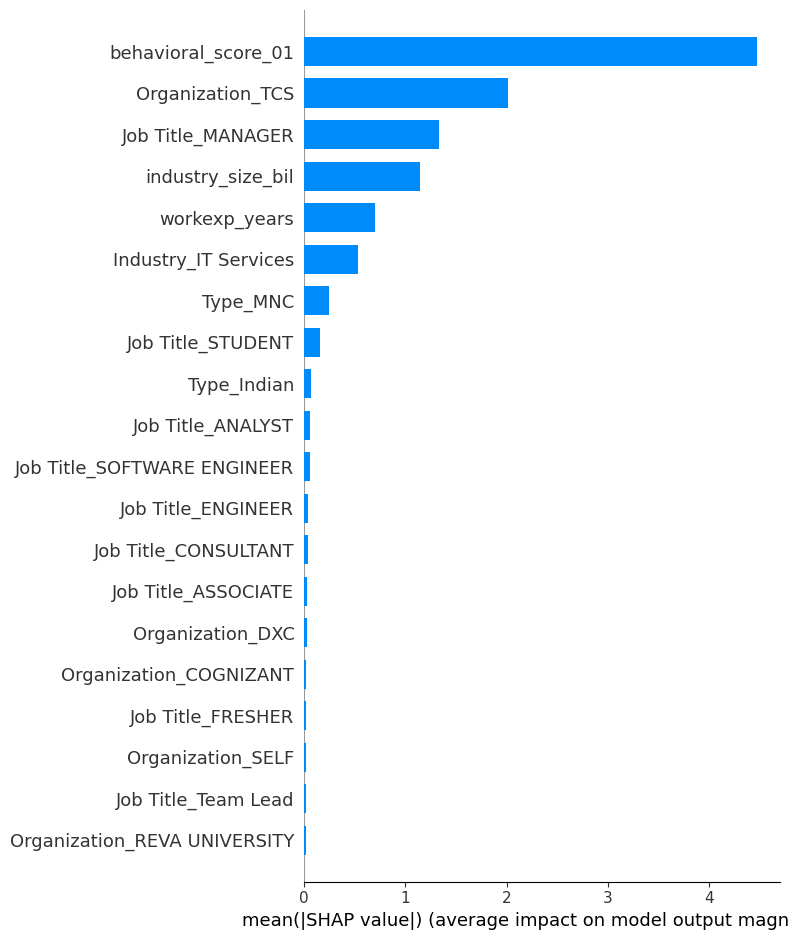

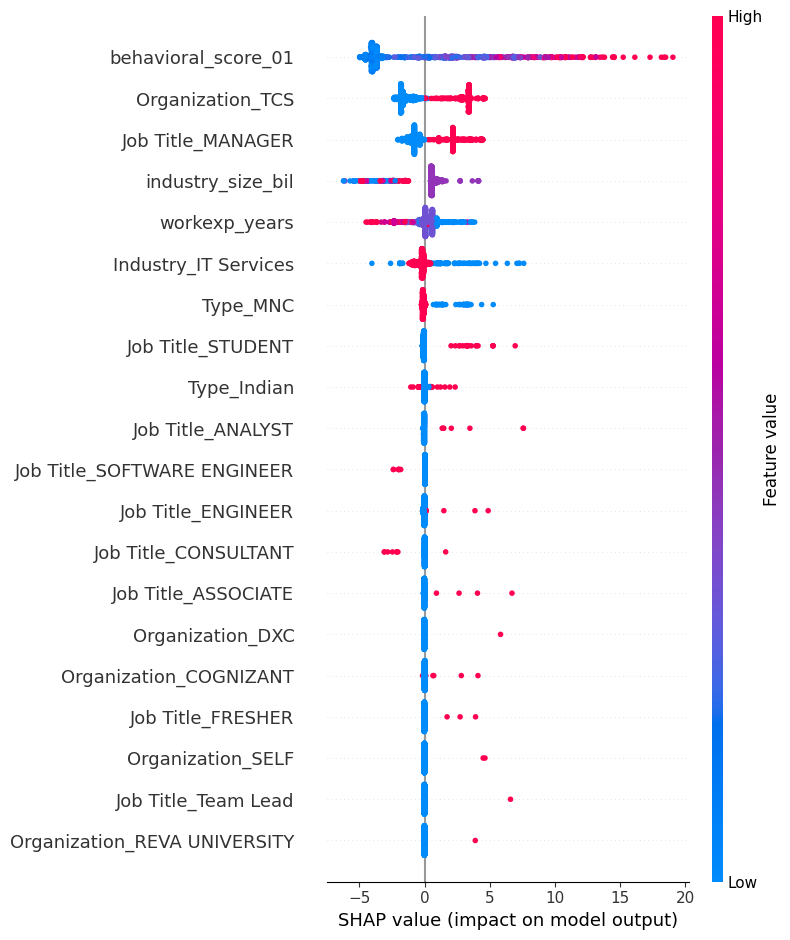

In [72]:
# swap clf to LightGBM
lgb_clf = lgbm_hybrid_pipe.named_steps["clf"]
explainer = shap.TreeExplainer(lgb_clf.booster_)   # LightGBM exposes .booster_
shap_vals = explainer.shap_values(Xvis_dense, check_additivity=False)
shap.summary_plot(shap_vals, Xvis_dense, feature_names=feat_names, plot_type="bar")
shap.summary_plot(shap_vals, Xvis_dense, feature_names=feat_names)


In [73]:
from sklearn.inspection import permutation_importance
import pandas as pd, matplotlib.pyplot as plt

result = permutation_importance(xgb_hybrid_pipe, Xh_test, yh_test,
                                scoring="f1", n_repeats=5, random_state=42, n_jobs=-1)

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(range(len(imp_df)), imp_df["importance"])
plt.yticks(range(len(imp_df)), imp_df["feature"])
plt.gca().invert_yaxis()
plt.title("Permutation Importance — Hybrid XGBoost (F1 drop)")
plt.tight_layout(); plt.show()


ValueError: All arrays must be of the same length